# Introduction

Sunspots are regions on the sun's surface that are cooler than the surrounding areas and so appear darker. Sunspots have been observed continuously since 1609, and the first observation dates back a 100 years in china, If sunspots are active, more solar flares will result creating an increase in geomagnetic storm activity for Earth. Therefore during sunspot maximums, the Earth will see an increase in the Northern and Southern Lights and a possible disruption in radio transmissions and power grids.


In [242]:
from IPython.display import YouTubeVideo 
YouTubeVideo('rx9m6H6GeLs', width=1000, height=400) # Relevant till 3:00

# Imports

In [1769]:
%load_ext autoreload
%autoreload 2
# Data Wrangling & stats
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Helper Handles
from helperhandler import dataHolder
from helperhandler import get_ts_strength, adf_test, kpss_test
from helperhandler import ro_framework, residual_diagnostic

# Models & Stats
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from statsmodels.nonparametric.smoothers_lowess import lowess


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Path and Variable Initialisations

In [1329]:
root_path = '../'
raw_datapath = root_path+'Raw Data/'
prepared_datapath = root_path+'Prepared Data/'

In [1361]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,7)
plt.style.use('dark_background')
# plt.style.use('ggplot')

# Load and Explore the Data

[Forecasting with long seasonal periods](https://robjhyndman.com/hyndsight/longseasonality/)

In [273]:
dataHolder.load_data()
dataHolder.dataDf.tail()

Handle       Short Description
10  anti_diabetic  AntiDiabetic Drug Sale
11   aus_elecprod  Electricity Production
12    visitor_20r  Visitors to 20 Regions
13   usa_economic    USA Economic Numbers
14       sunspots         Sunspot Numbers

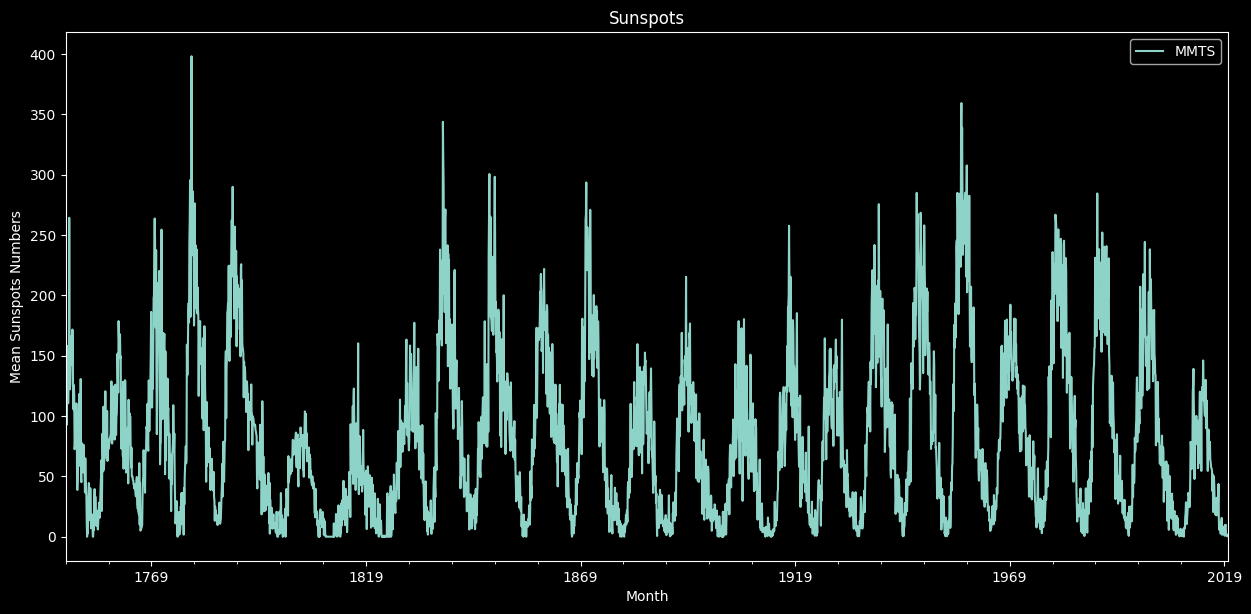

In [274]:
dataobj = dataHolder.bucket['sunspots']
sundata = dataobj.data.copy()
dataHolder.bucket['sunspots'].exploratory_plot()

In [275]:
sundata.index.freq = 'M'
sundata.head()

MMTS
Month            
1749-01-31   96.7
1749-02-28  104.3
1749-03-31  116.7
1749-04-30   92.8
1749-05-31  141.7

# In-Depth Exploratory Data Analysis & Data Preperation

## Time Series Plot

Try slicing the data and see if you can find the following properties, and quantify them :
- Monthly Seasonality
- Cyclicity

Starting from 12, 24, 36... 11 years=122, 12 years = 144

In [1127]:
sundata = dataobj.data.copy()

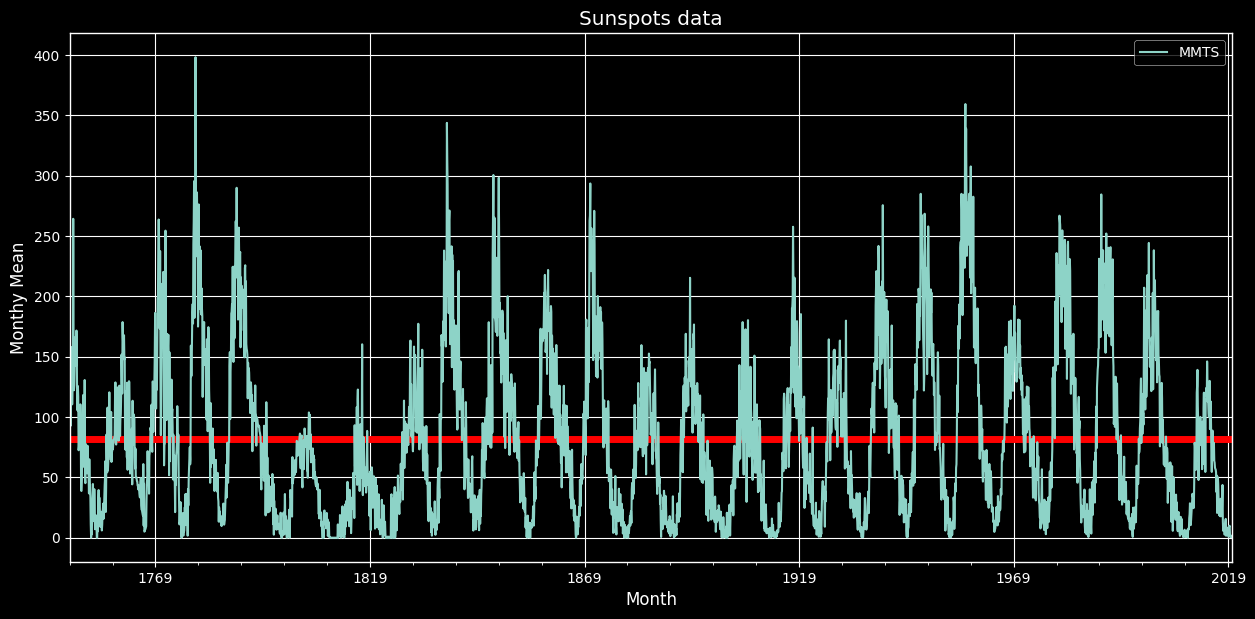

In [1128]:
_=sundata.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(sundata.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

In [1129]:
sundata.mean()

MMTS    82.070695
dtype: float64

## NaNs and Zeros in the data

In [1130]:
(sundata==np.nan).sum()

MMTS    0
dtype: int64

In [1131]:
(sundata==0.0).sum()

MMTS    67
dtype: int64

<b>There are 67 0.0 in the dataset, which are not supposed to be `Wrong` or `Outliers`  but can be problematic in later stages, how about we try to impute that?</b>

Were we to keep this :-

- We wont be able to use `MAPE` as our metric, which we are going to use
- We wont be able to apply some of the transformations to it

Maybe with the next smallest value in the series??

In [1132]:
sorted(sundata.MMTS.unique())[:10]

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [1133]:
next_min = 0.2
sundata.replace({0.0:next_min}).min()

MMTS    0.2
dtype: float64

In [1134]:
sundata=sundata.replace({0.0:next_min})

<b>Lets see how our Time Series looks now</b>

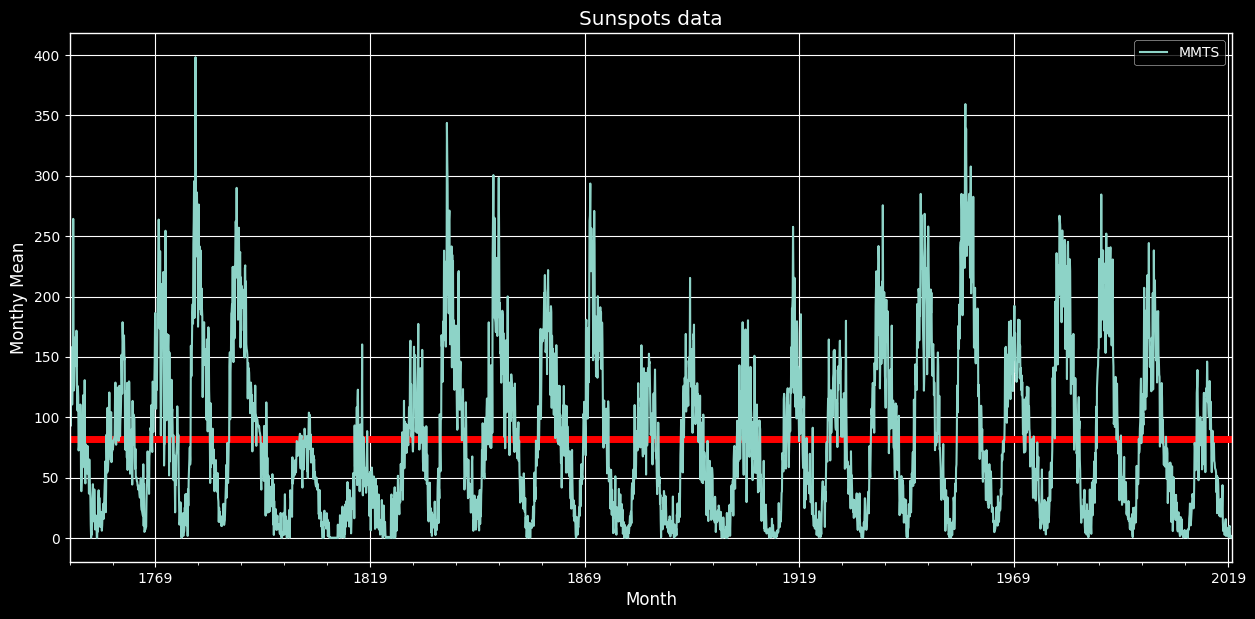

In [1135]:
_=sundata.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(sundata.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

In [1136]:
sundata.mean()

MMTS    82.074815
dtype: float64

## Gauging into the cycles

In [1137]:
sundata = sundata[sundata.index>='1901-11-30'].copy()

<AxesSubplot:xlabel='Month'>

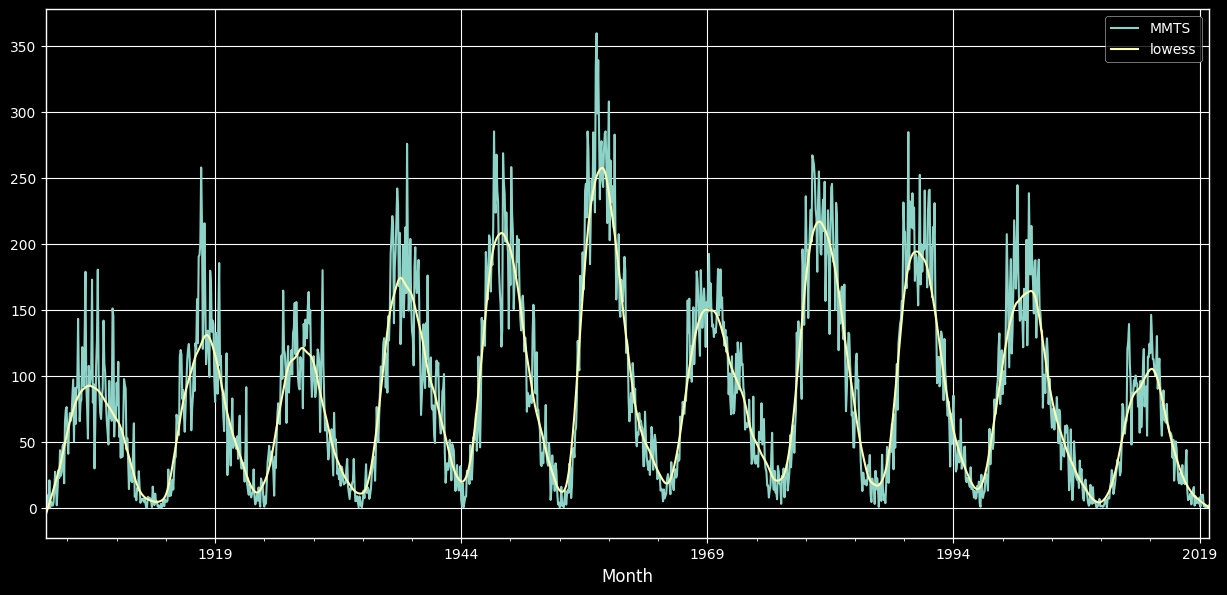

In [1141]:
sundata['lowess'] = lowess(sundata.MMTS, sundata.reset_index().index, 0.025)[:,1]
sundata.plot()

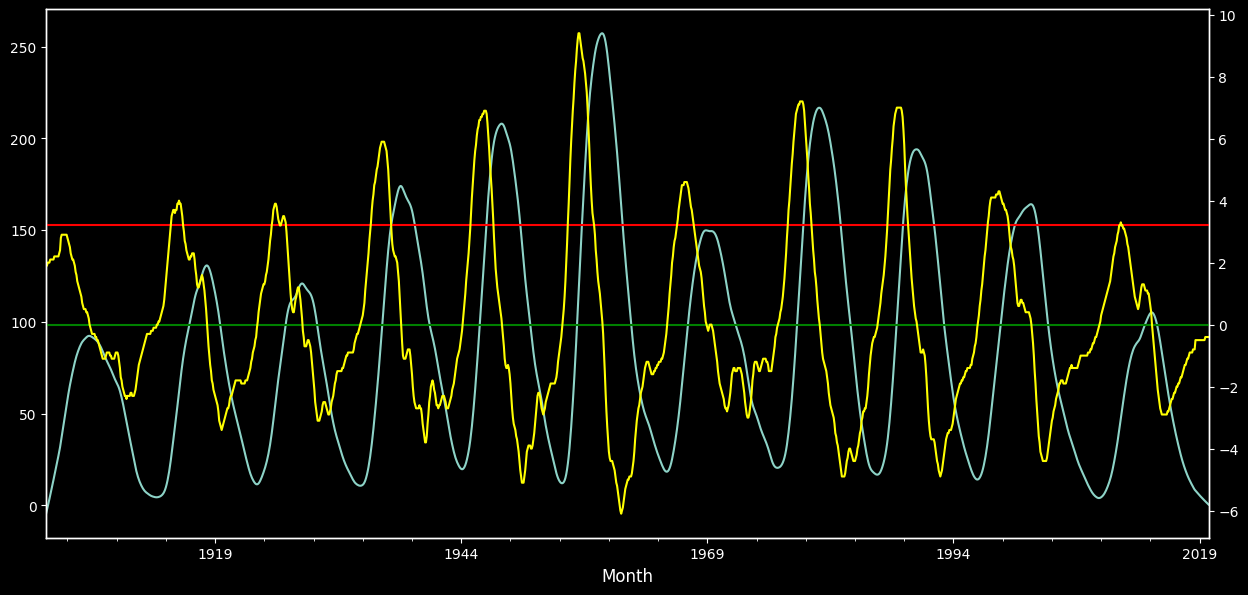

In [1143]:
sundata.lowess.plot()
plt.grid(b=None)
dx = plt.twinx()
sundata['slope'] = np.round(sundata['lowess'].diff(),1).bfill()
sundata['inflected'] = sundata['slope']>0.0
sundata['slope'].plot(ax=dx, color='yellow')
dx.hlines(3.2, sundata.index.min(),sundata.index.max(), color='red')
dx.hlines(0.0, sundata.index.min(),sundata.index.max(), color='g')
dx.grid(b=None)

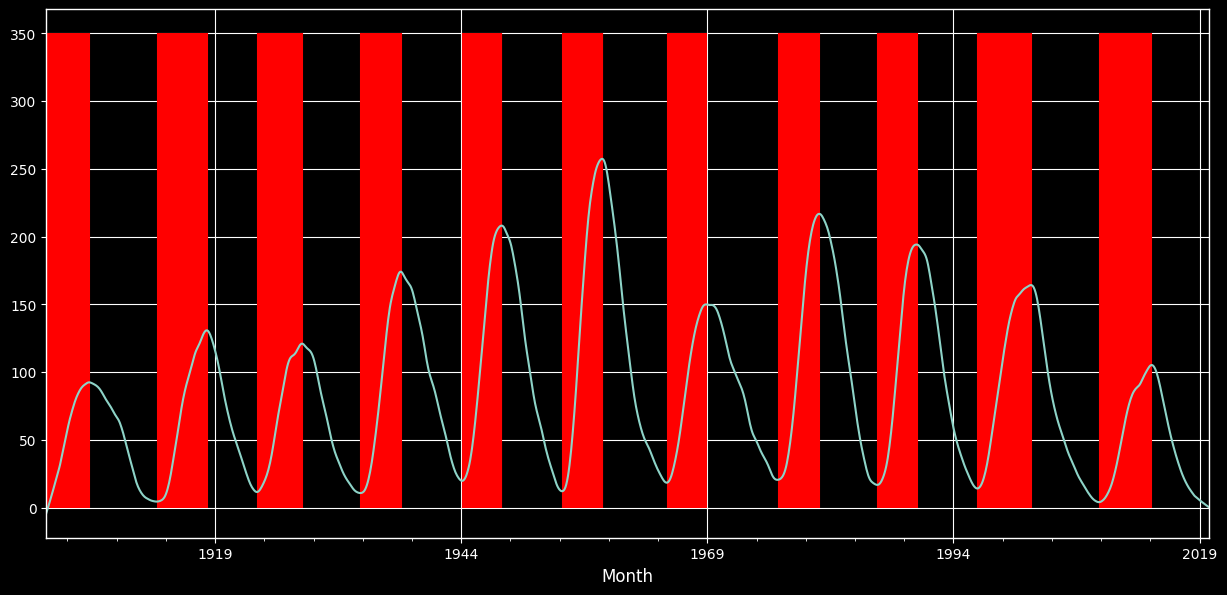

In [1144]:
sundata['lowess'].plot()
plt.vlines(sundata[sundata.inflected].index,
           0,350, color='red')

In [1145]:
sundata.inflected.astype(int)[130:150]
# .diff()

Month
1912-09-30    0
1912-10-31    0
1912-11-30    0
1912-12-31    0
1913-01-31    0
1913-02-28    0
1913-03-31    0
1913-04-30    1
1913-05-31    1
1913-06-30    1
1913-07-31    1
1913-08-31    1
1913-09-30    1
1913-10-31    1
1913-11-30    1
1913-12-31    1
1914-01-31    1
1914-02-28    1
1914-03-31    1
1914-04-30    1
Freq: M, Name: inflected, dtype: int64

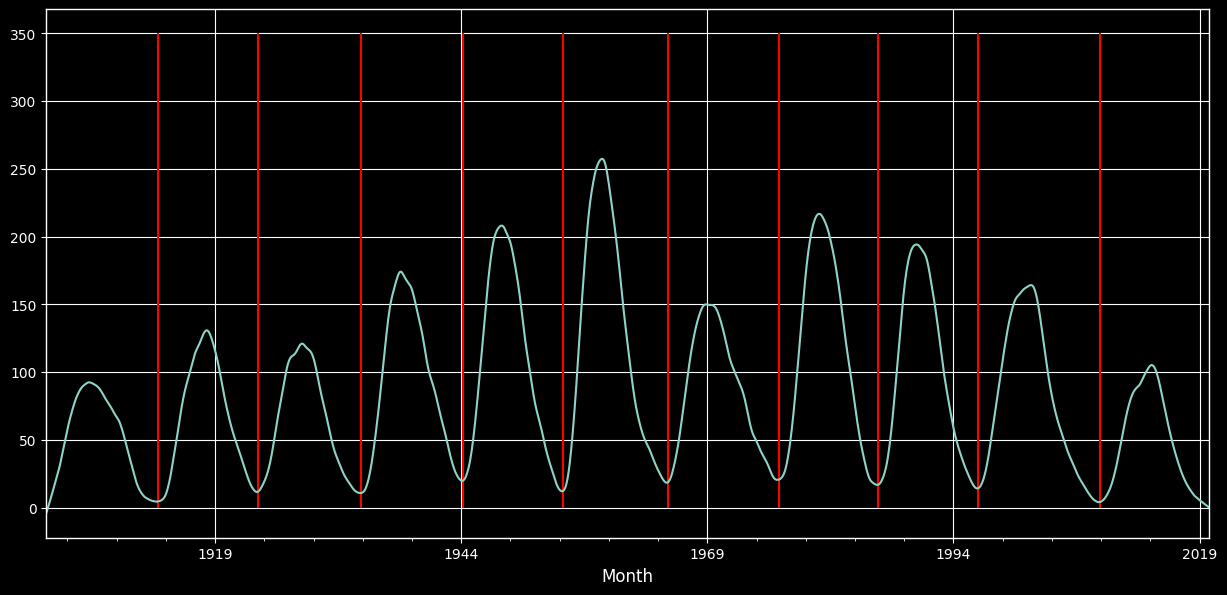

In [1146]:
sundata['cycle_shift'] = sundata.inflected.astype(int).diff(1)==1
sundata['cycle_no'] = sundata.cycle_shift.cumsum()+1
sundata['lowess'].plot()
plt.vlines(sundata[sundata.cycle_shift].index,
           0,350, color='red')

In [1147]:
cycle_dates = pd.DataFrame(columns=['Begin', 'End'])
cycle_dates['Begin'] = sundata.reset_index().groupby('cycle_no').Month.first()
cycle_dates['End'] = sundata.reset_index().groupby('cycle_no').Month.last()
cycle_dates['Diff_Months'] = cycle_dates.apply(lambda x : (x.End-x.Begin)/np.timedelta64(1, 'M'), axis=1)
cycle_dates

Begin        End  Diff_Months
cycle_no                                   
1        1901-11-30 1913-03-31   135.986365
2        1913-04-30 1923-04-30   119.986037
3        1923-05-31 1933-10-31   125.045689
4        1933-11-30 1944-02-29   122.975831
5        1944-03-31 1954-04-30   120.971683
6        1954-05-31 1964-12-31   127.049837
7        1965-01-31 1976-03-31   133.949362
8        1976-04-30 1986-04-30   119.986037
9        1986-05-31 1996-06-30   121.004538
10       1996-07-31 2008-11-30   148.011253
11       2008-12-31 2019-12-31   131.978069

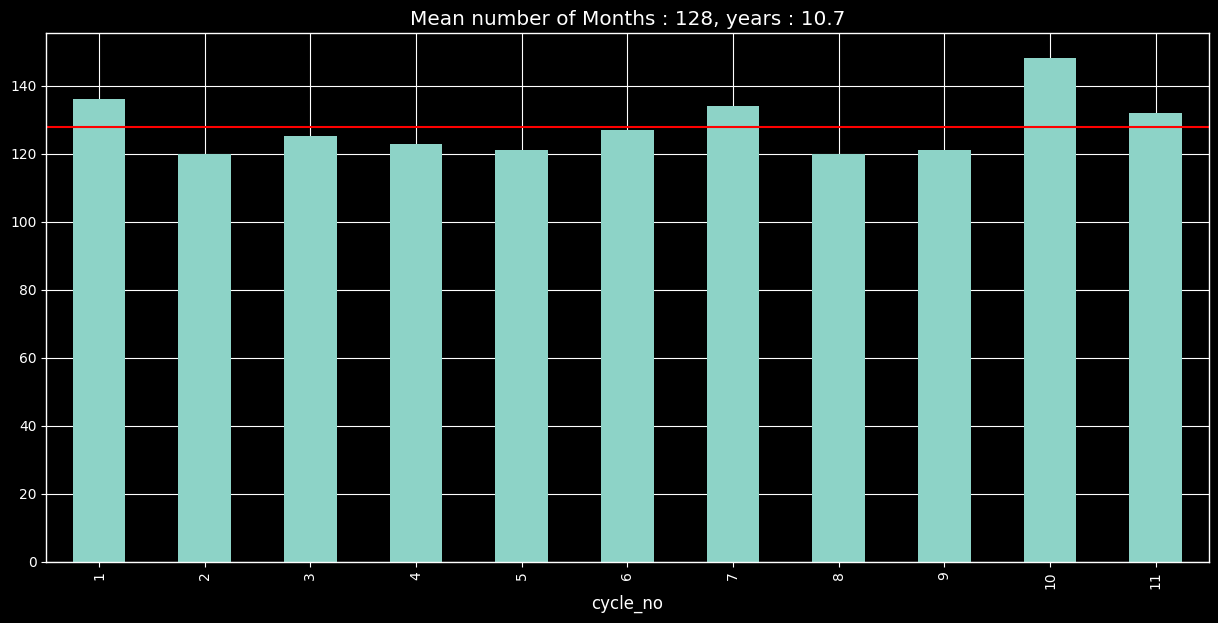

In [1148]:
cycle_dates.Diff_Months.plot(kind='bar')
plt.hlines(cycle_dates.Diff_Months.mean(),
           -1,
           cycle_dates.index.max(),
           color='r')

_mean_months = int(round(cycle_dates.Diff_Months.mean()))
_mean_years = round(_mean_months/12,1)
_=plt.title('Mean number of Months : {0}, years : {1}'.format(_mean_months, _mean_years))

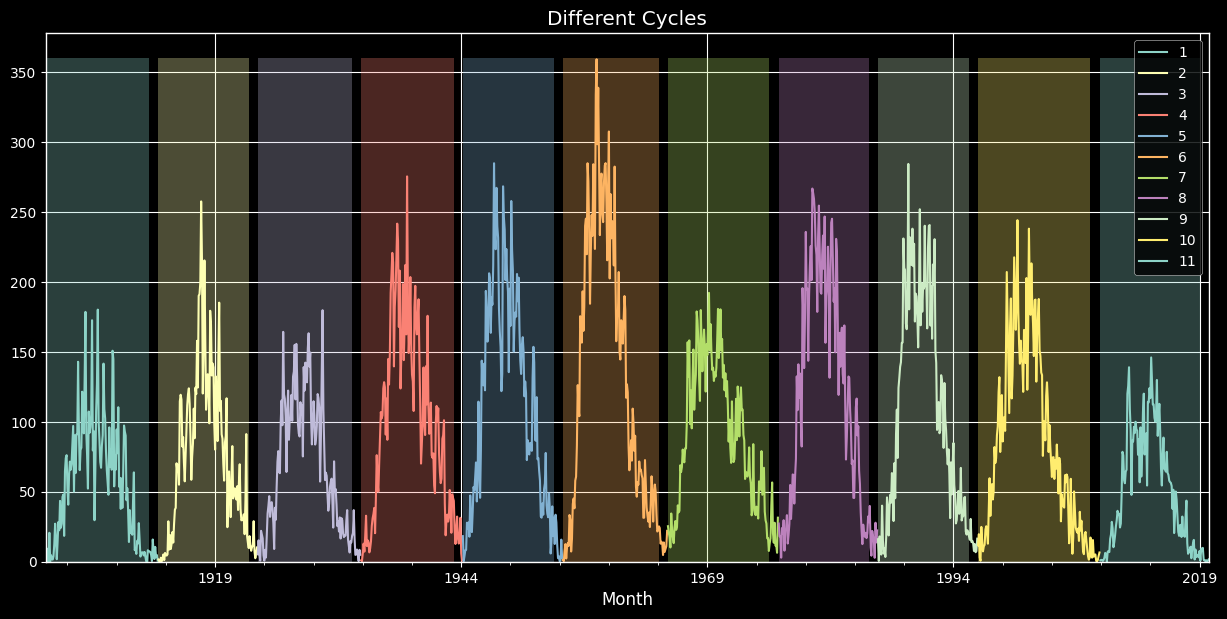

In [1149]:
import matplotlib.dates as mdates
_=sundata.groupby('cycle_no').MMTS.plot(legend=True, title='Different Cycles')
for edt, ecyc in cycle_dates.iterrows():
    plt.bar(ecyc.Begin, 360, ecyc.Diff_Months*(125/135.986365), alpha=0.3, align='edge')

In [1150]:
sundata.head()

MMTS    lowess  slope  inflected  cycle_shift  cycle_no
Month                                                              
1901-11-30   6.4 -4.568610    1.9       True        False         1
1901-12-31   0.2 -2.631277    1.9       True        False         1
1902-01-31   9.3 -0.664444    2.0       True        False         1
1902-02-28   0.2  1.332298    2.0       True        False         1
1902-03-31  20.7  3.358342    2.0       True        False         1

<AxesSubplot:xlabel='Month'>

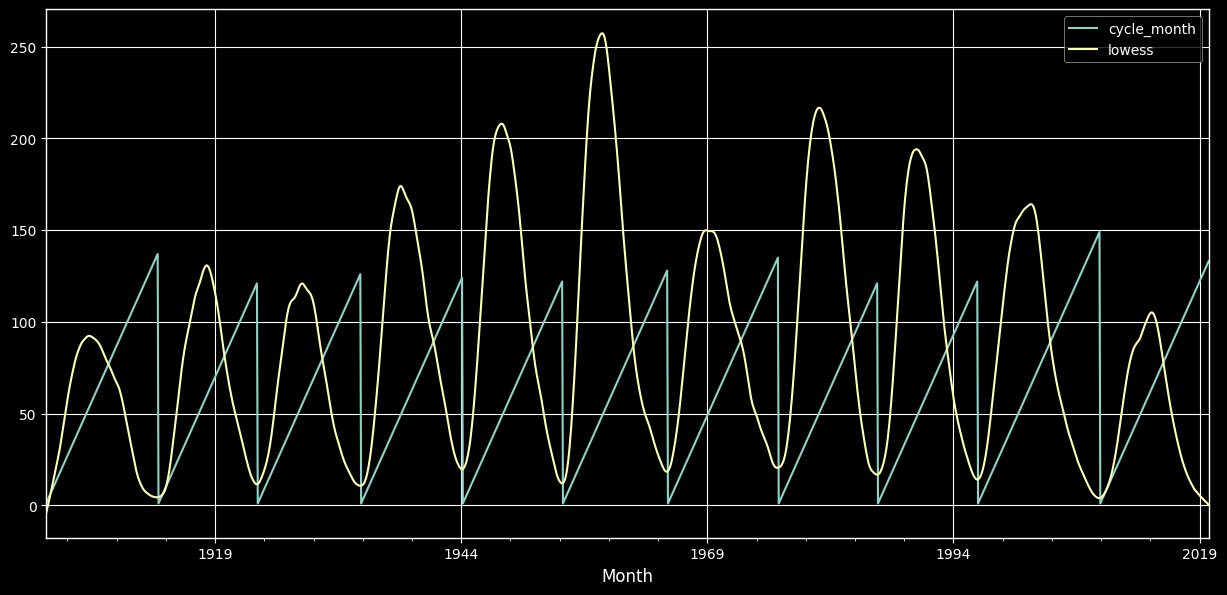

In [1184]:
sundata['cycle_month']= (sundata.groupby('cycle_no').cycle_no.cumsum()/sundata.cycle_no).astype(int)
sundata[['cycle_month', 'lowess']].plot()

## Distribution of the data

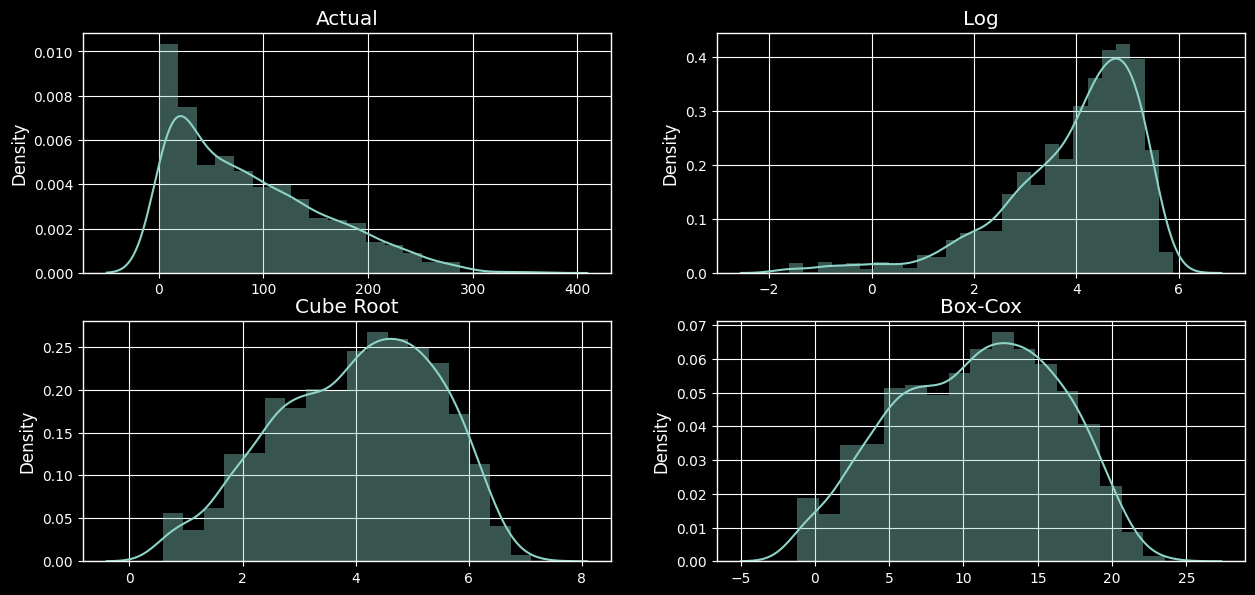

In [1181]:
fig, axes = plt.subplots(2,2)
a,b=boxcox(sundata.MMTS)
_=sns.distplot(sundata.MMTS, ax=axes[0,0])
_=sns.distplot(np.log(sundata.MMTS), ax=axes[0,1])
_=sns.distplot(np.power(sundata.MMTS,1/3), ax=axes[1,0])
_=sns.distplot(a, ax=axes[1,1])

axes[0,0].set_title('Actual')
axes[0,1].set_title('Log')
axes[1,0].set_title('Cube Root')
axes[1,1].set_title('Box-Cox')

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,0].set_xlabel('')
_=axes[1,1].set_xlabel('')


## Transformation on the data

In [1152]:
pltdata = sundata.copy()

In [1153]:
pltdata['MMTS_Adj'] = pltdata.MMTS/pltdata.index.daysinmonth
pltdata.head()

MMTS    lowess  slope  inflected  cycle_shift  cycle_no  MMTS_Adj
Month                                                                        
1901-11-30   6.4 -4.568610    1.9       True        False         1  0.213333
1901-12-31   0.2 -2.631277    1.9       True        False         1  0.006452
1902-01-31   9.3 -0.664444    2.0       True        False         1  0.300000
1902-02-28   0.2  1.332298    2.0       True        False         1  0.007143
1902-03-31  20.7  3.358342    2.0       True        False         1  0.667742

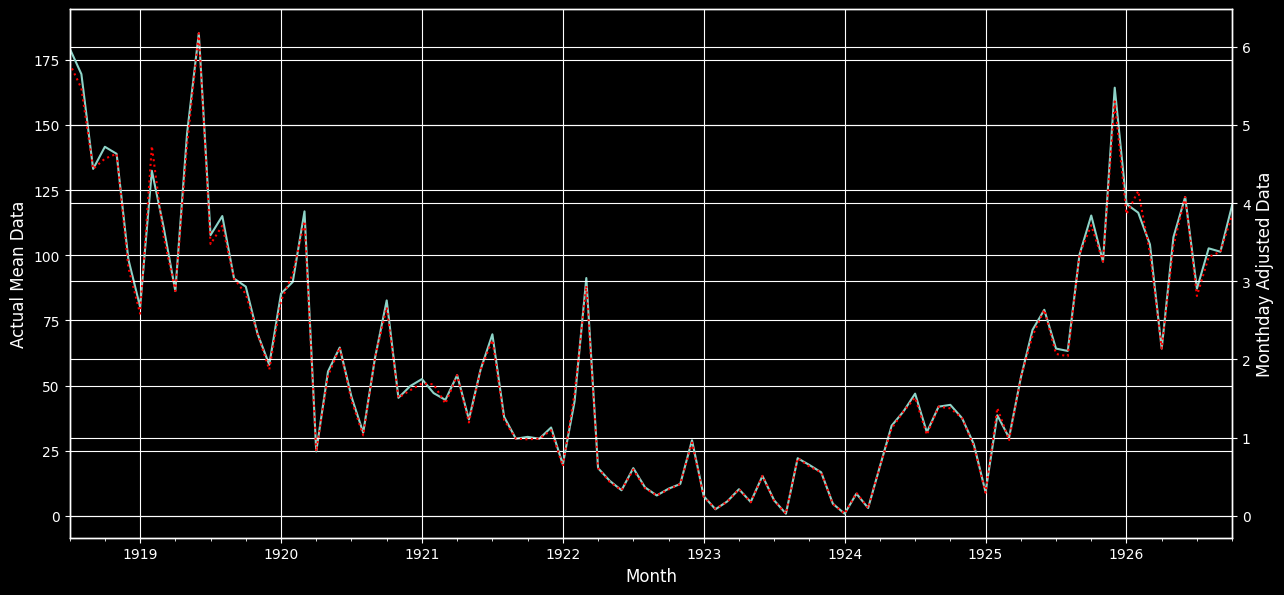

In [1154]:
pltdata = pltdata[200:300]
fig, axes=plt.subplots()
_=pltdata.MMTS.plot(ax=axes)
_=axes.set_ylabel('Actual Mean Data')
dx = axes.twinx()
_=pltdata.MMTS_Adj.plot(ax=dx, color='red', linestyle=':')
_=dx.set_ylabel('Monthday Adjusted Data')

<b>Log Transformation</b>

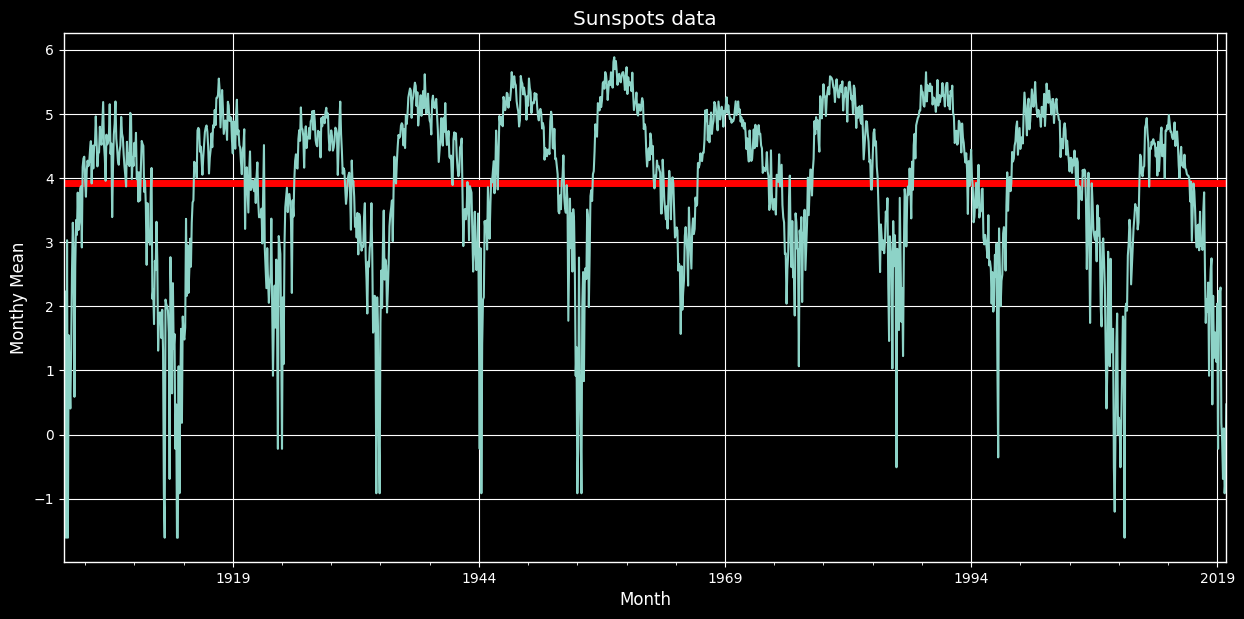

In [1155]:
_=np.log(sundata.MMTS).plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(np.log(sundata.MMTS).mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

<b>Cube Root Transformation</b>

In [1156]:
transformed_series = np.power(sundata.MMTS, 1/3)

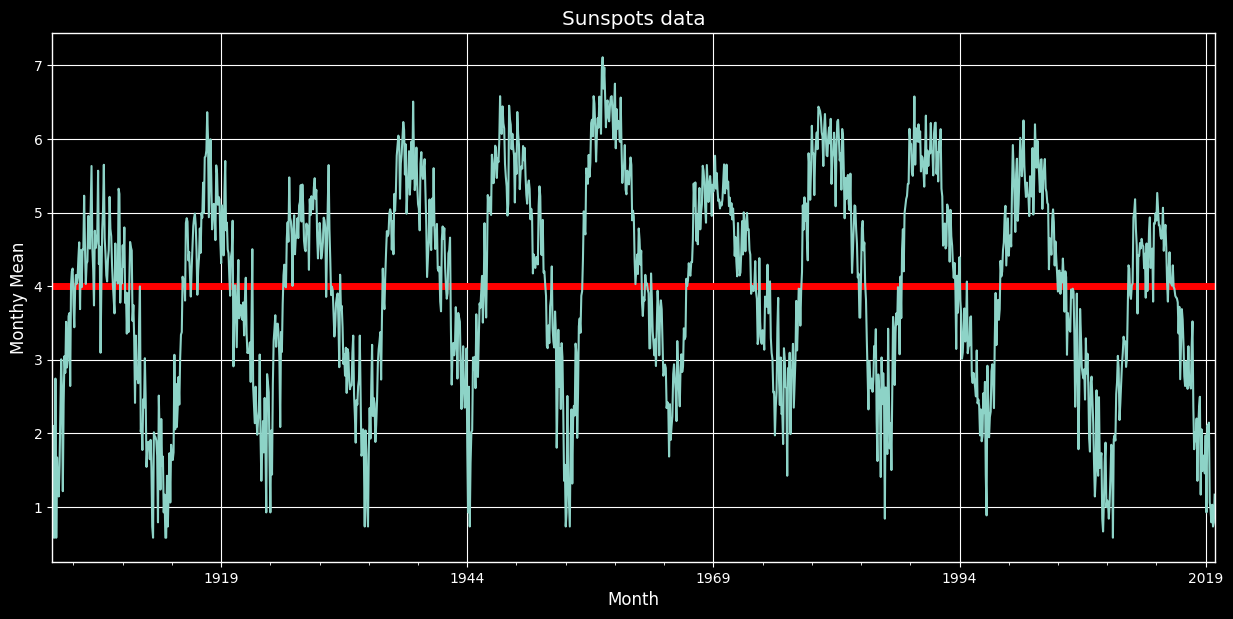

In [1157]:
_=transformed_series.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(transformed_series.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

<b>BoxCox Transformations</b>

In [1158]:
transformed_series, bc_lambda = boxcox(sundata.MMTS)
transformed_series = pd.Series(transformed_series, index=sundata.index)

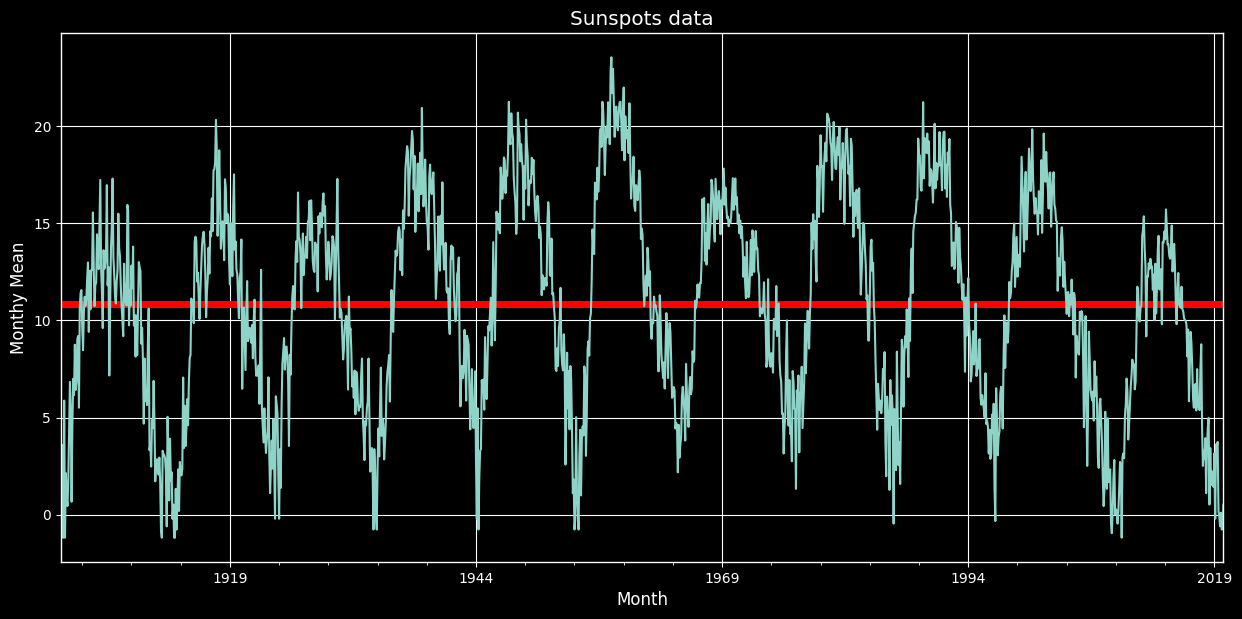

In [1159]:
_=transformed_series.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(transformed_series.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

<b>Given that some values are in the negative, we wont be able to use multiplicative decompising models</b>

In [1240]:
sundata_transformed = sundata.copy()
sundata_transformed.MMTS = np.power(sundata.MMTS, 1/3)
sundata_transformed.head()

MMTS    lowess  slope  inflected  cycle_shift  cycle_no  \
Month                                                                     
1901-11-30  1.856636 -4.568610    1.9       True        False         1   
1901-12-31  0.584804 -2.631277    1.9       True        False         1   
1902-01-31  2.102944 -0.664444    2.0       True        False         1   
1902-02-28  0.584804  1.332298    2.0       True        False         1   
1902-03-31  2.745723  3.358342    2.0       True        False         1   

            cycle_month  
Month                    
1901-11-30            1  
1901-12-31            2  
1902-01-31            3  
1902-02-28            4  
1902-03-31            5

## Seasonal/Variation Plot

In [1162]:
pltdata = sundata.copy()

In [1163]:
pltdata['Year'] = pltdata.index.year
pltdata['Month'] = pltdata.index.month
pltdata.head()

MMTS    lowess  slope  inflected  cycle_shift  cycle_no  Year  \
Month                                                                       
1901-11-30   6.4 -4.568610    1.9       True        False         1  1901   
1901-12-31   0.2 -2.631277    1.9       True        False         1  1901   
1902-01-31   9.3 -0.664444    2.0       True        False         1  1902   
1902-02-28   0.2  1.332298    2.0       True        False         1  1902   
1902-03-31  20.7  3.358342    2.0       True        False         1  1902   

            Month  
Month              
1901-11-30     11  
1901-12-31     12  
1902-01-31      1  
1902-02-28      2  
1902-03-31      3

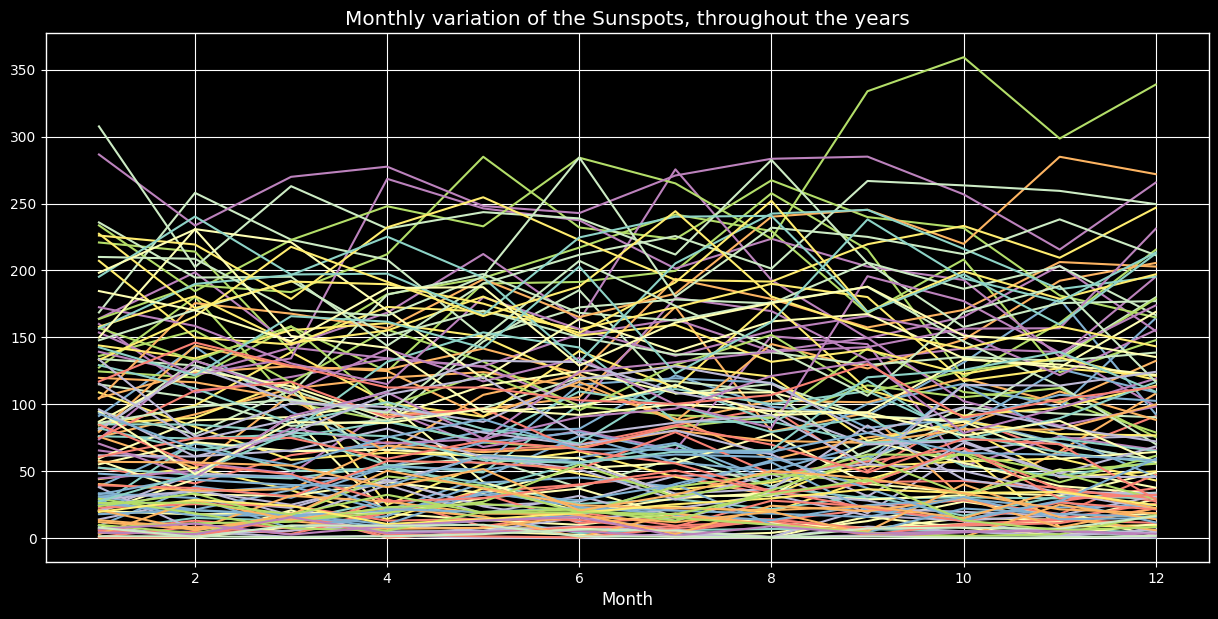

In [1164]:
# For checking monthly seasonality
sundata_monthp = pltdata.pivot(index='Month', columns='Year', values='MMTS')
_=sundata_monthp.plot(legend=None,
                      title='Monthly variation of the Sunspots, throughout the years')

## Chop Plot

In [1165]:
pltdata = sundata.copy()[7*12:]

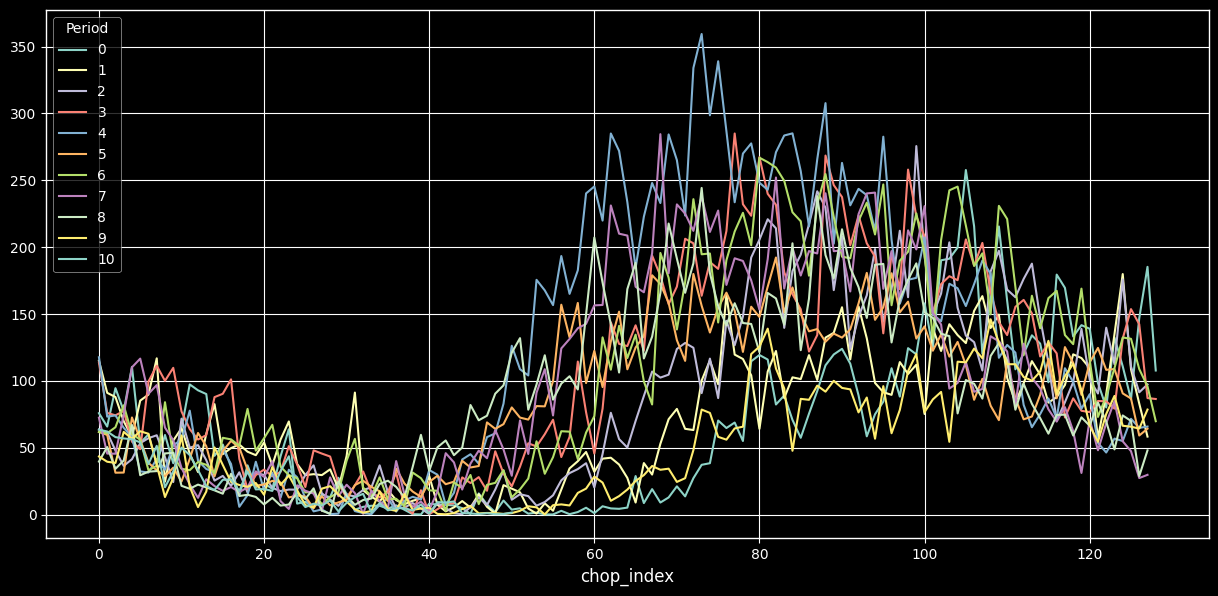

In [1167]:
chop_indices = []
for each_period_counts in pltdata.groupby('Period').size().values:
    chop_indices += list(range(each_period_counts))
pltdata['chop_index'] = chop_indices
pltdata_chop = pltdata.pivot(index='chop_index',
                             columns='Period',
                             values='MMTS')
_=pltdata_chop.plot()

## Box  & Violin Plot

See as to which `period` makes the line more stable around the mean, to gauge into the Cyclicity behaviour of the model

In [1426]:
pltdata1 = sundata.copy()
pltdata2 = sundata_transformed.copy()

def get_boxp(data, xlabel):
    fig,axes = plt.subplots()
    data = data.copy()
    data.MMTS = data.MMTS.astype(float)
    _=sns.boxplot(x=xlabel,y='MMTS',data=data, ax=axes)
    _dmean = data.groupby(xlabel).MMTS.mean().reset_index()
    _=_dmean.MMTS.plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Box Plot')
    _=plt.xticks(rotation=90)
    
def get_violinp(data, xlabel):
    fig,axes = plt.subplots()
    data = data.copy()
    _=sns.violinplot(x=xlabel,y='MMTS',data=data, ax=axes)
    data.MMTS = data.MMTS.astype(float)
    _dmean = data.groupby(xlabel).MMTS.mean().reset_index()
    _=_dmean.MMTS.plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Violin Plot')



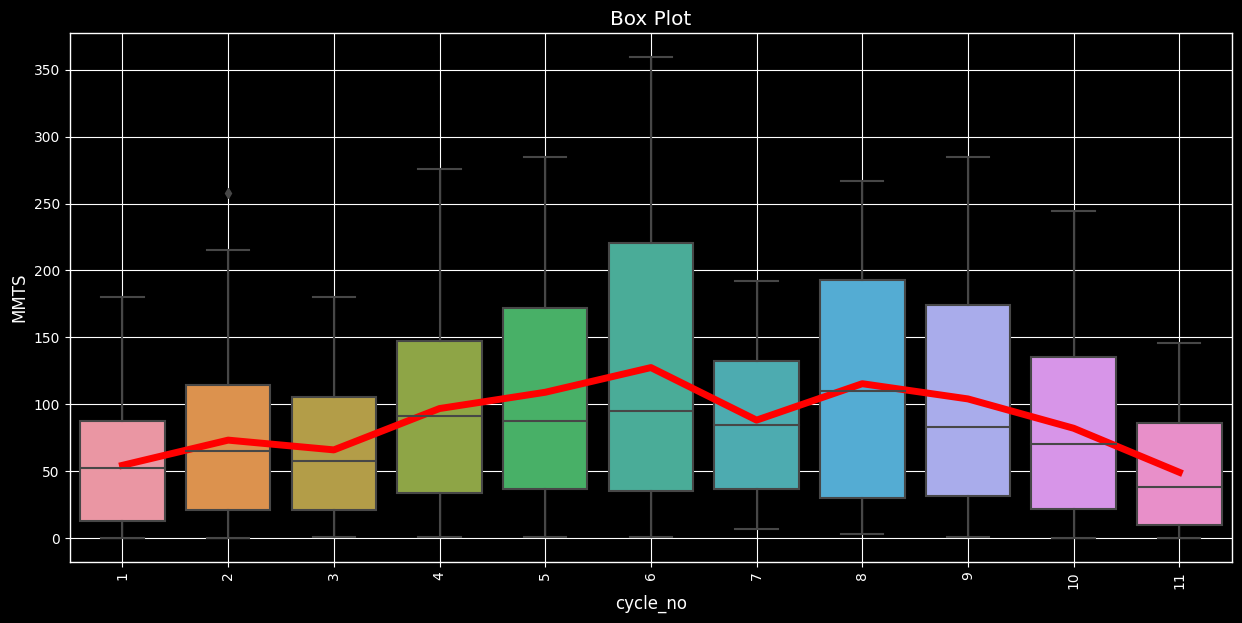

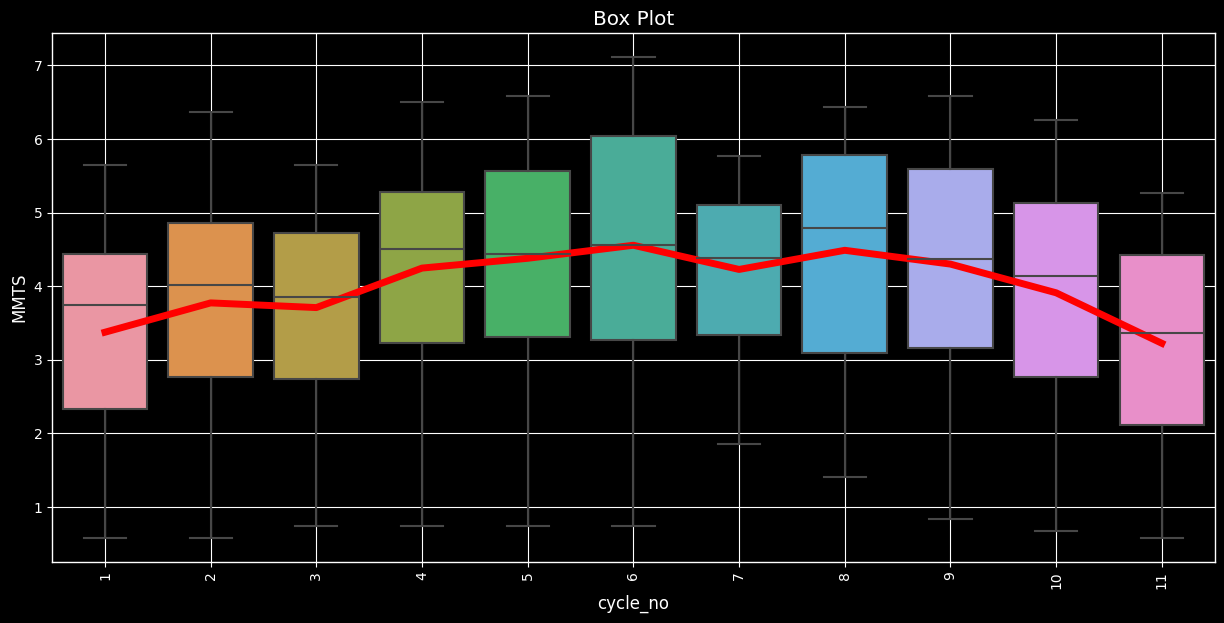

In [1427]:
get_boxp(pltdata1, 'cycle_no')
get_boxp(pltdata2, 'cycle_no')

<b>Well, it doesnt looks that the box plot has changed much...., so what has?<b>

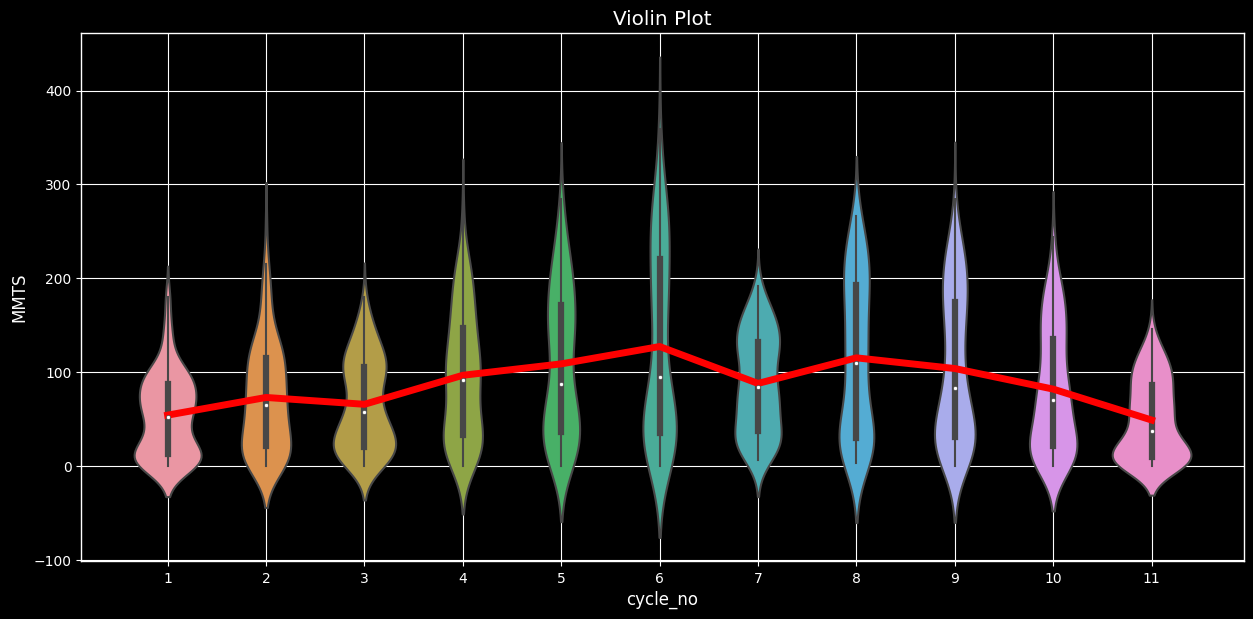

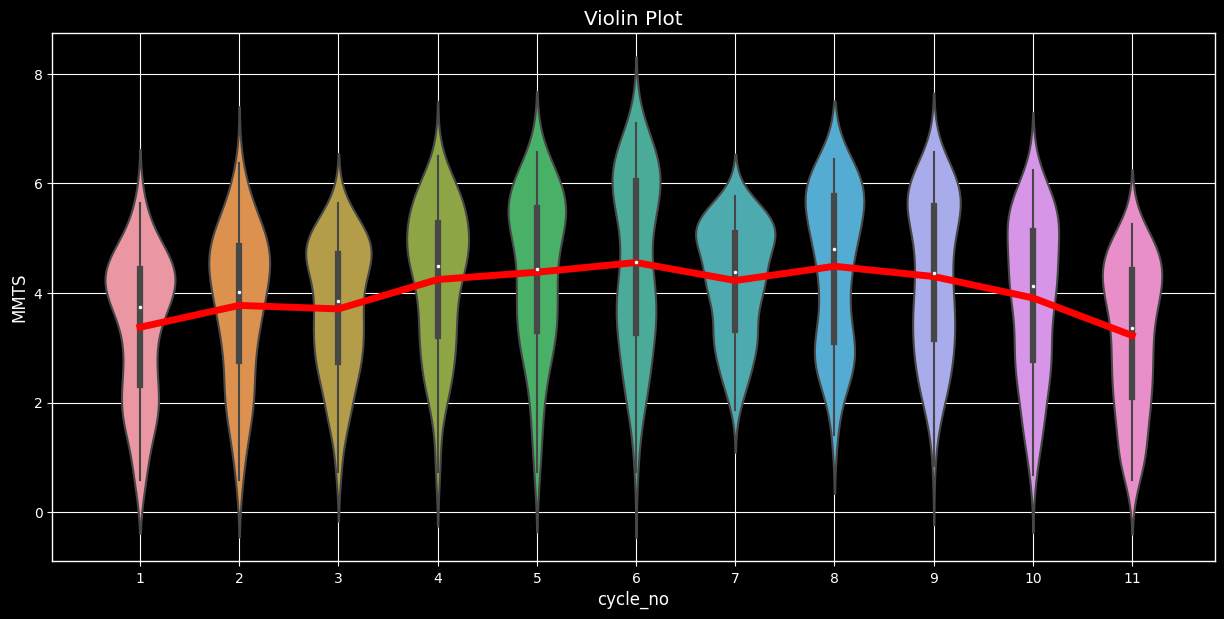

In [1428]:
get_violinp(pltdata1, 'cycle_no')
get_violinp(pltdata2, 'cycle_no')

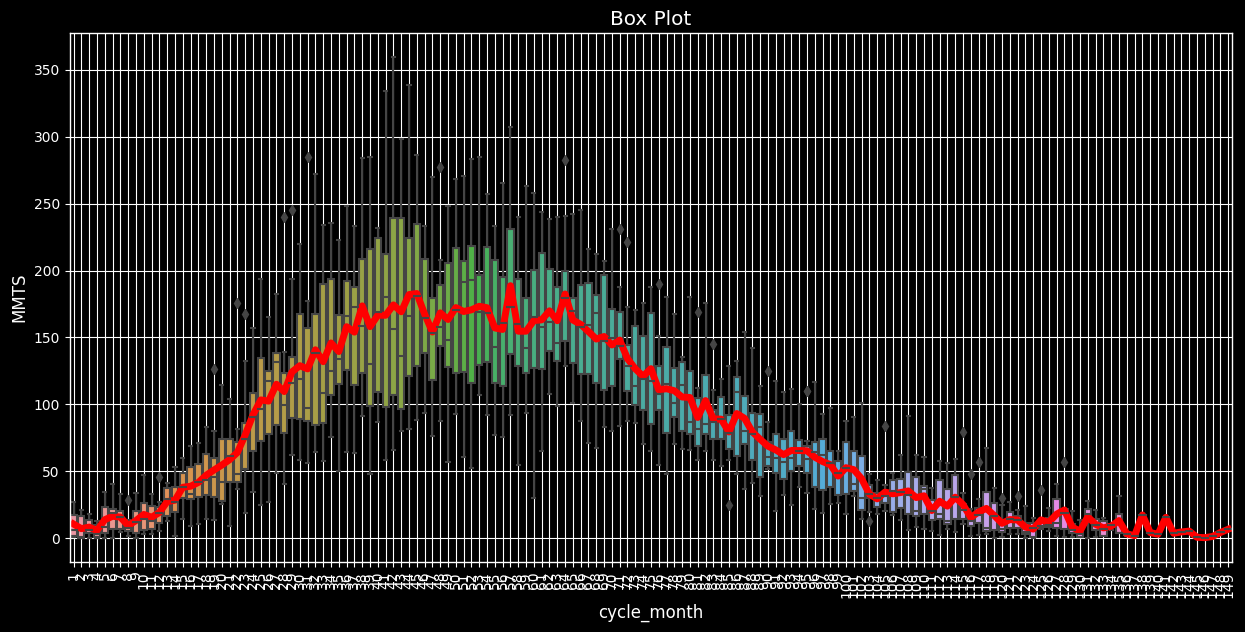

In [1429]:
get_boxp(sundata, 'cycle_month')

## Decomposition

The period parameter will be filled by the cyclic componet as observed in the 5.5 section, and then try for 12 to decompose for the yearly frequency.

Look at the extrapolate trend parameter

Trend  Seasonal
Strength  0.176792  0.288109

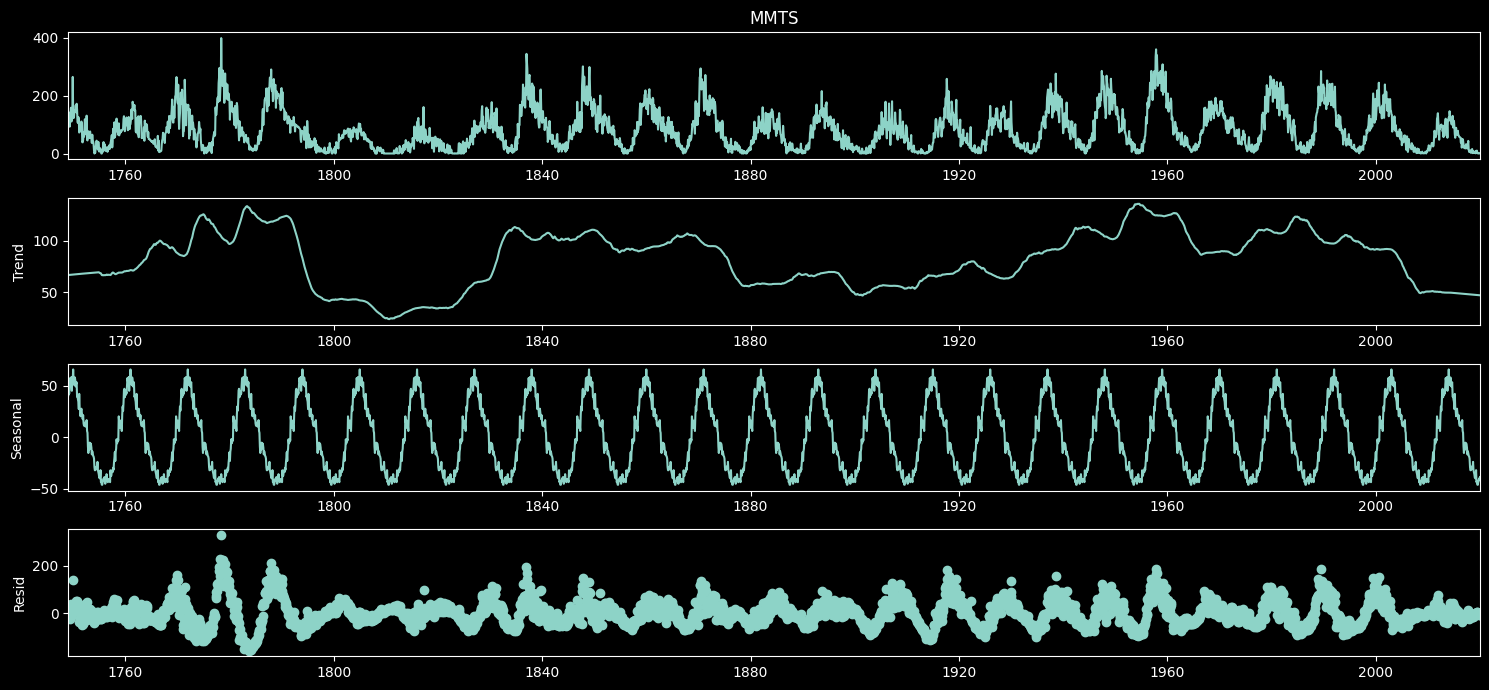

In [353]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='additive', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

Trend  Seasonal
Strength  0.999185  0.237728

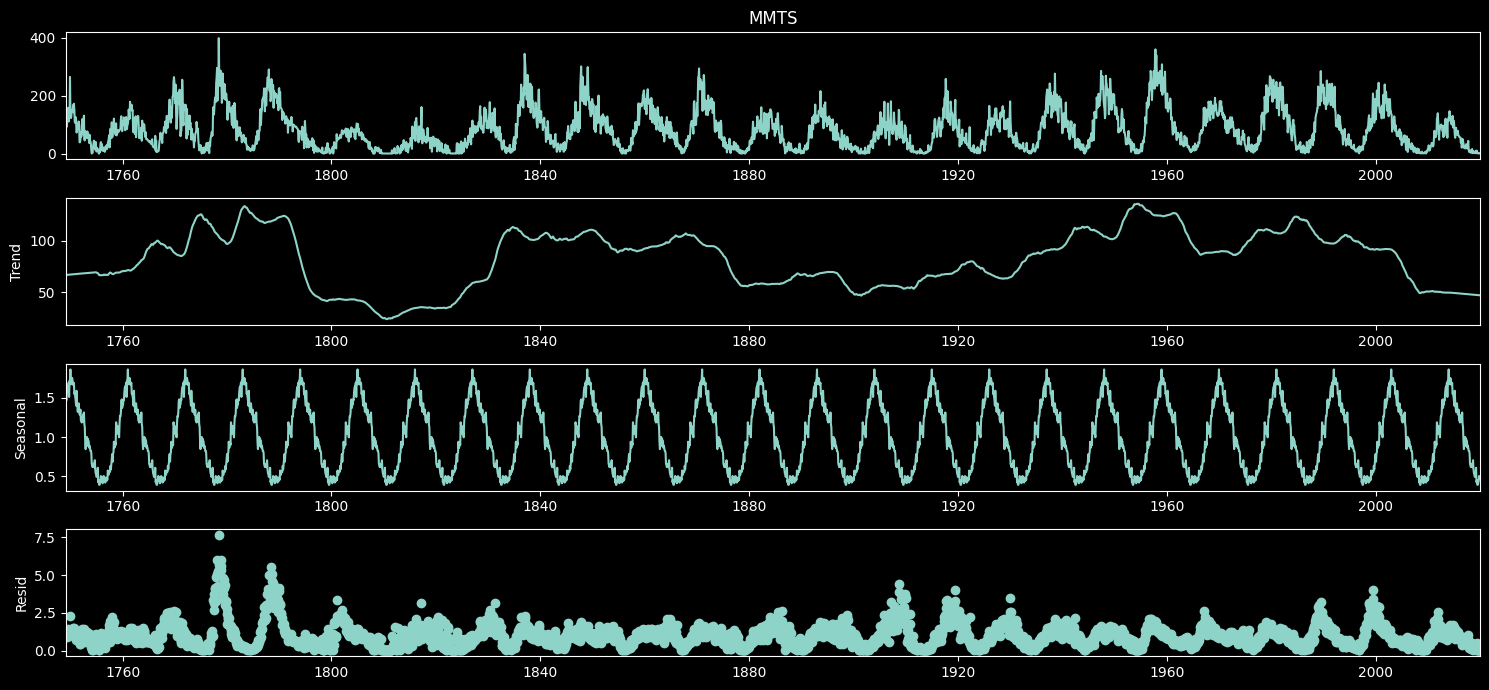

In [354]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='multiplicative', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

Trend  Seasonal
Strength  0.277994  0.728296

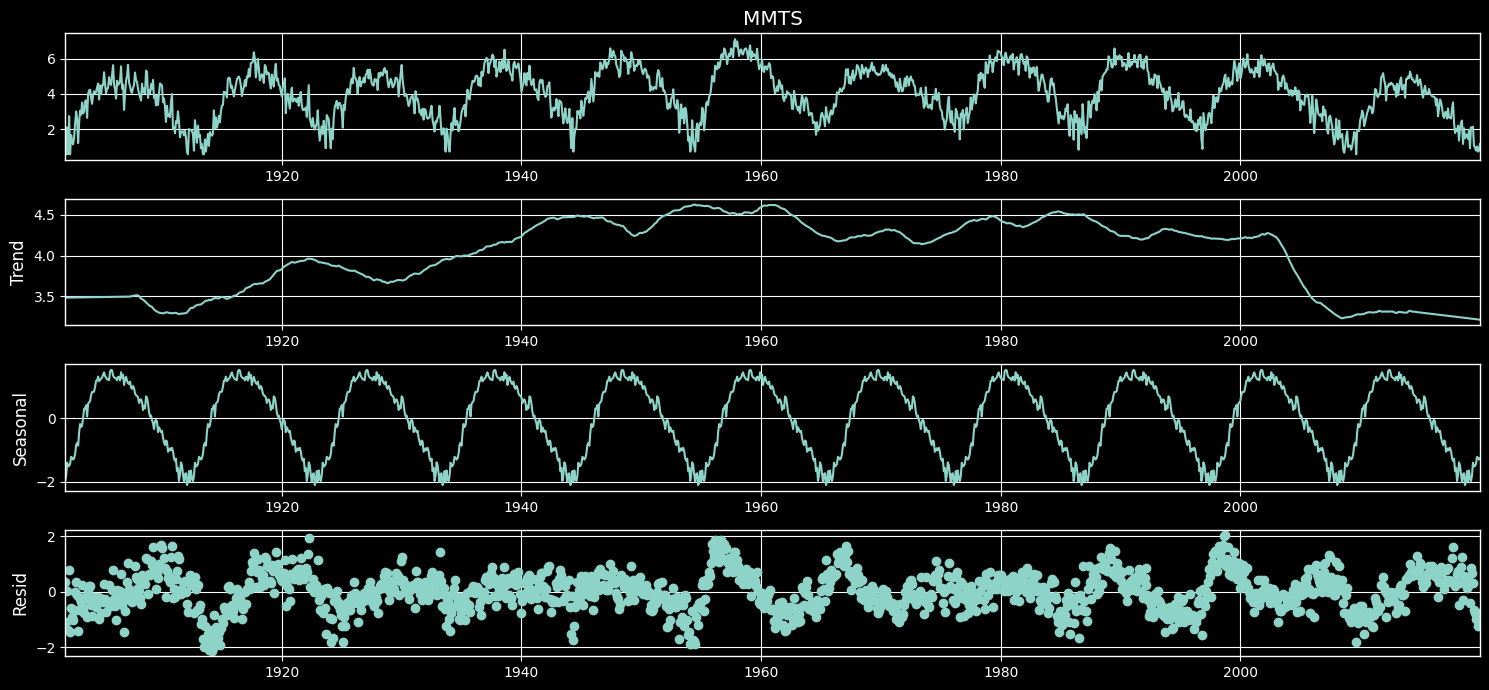

In [1629]:
adecomp_obj = seasonal_decompose(sundata_transformed.MMTS,
                                 model='additive',
                                 period=128, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

Trend  Seasonal
Strength  0.730293  0.351078

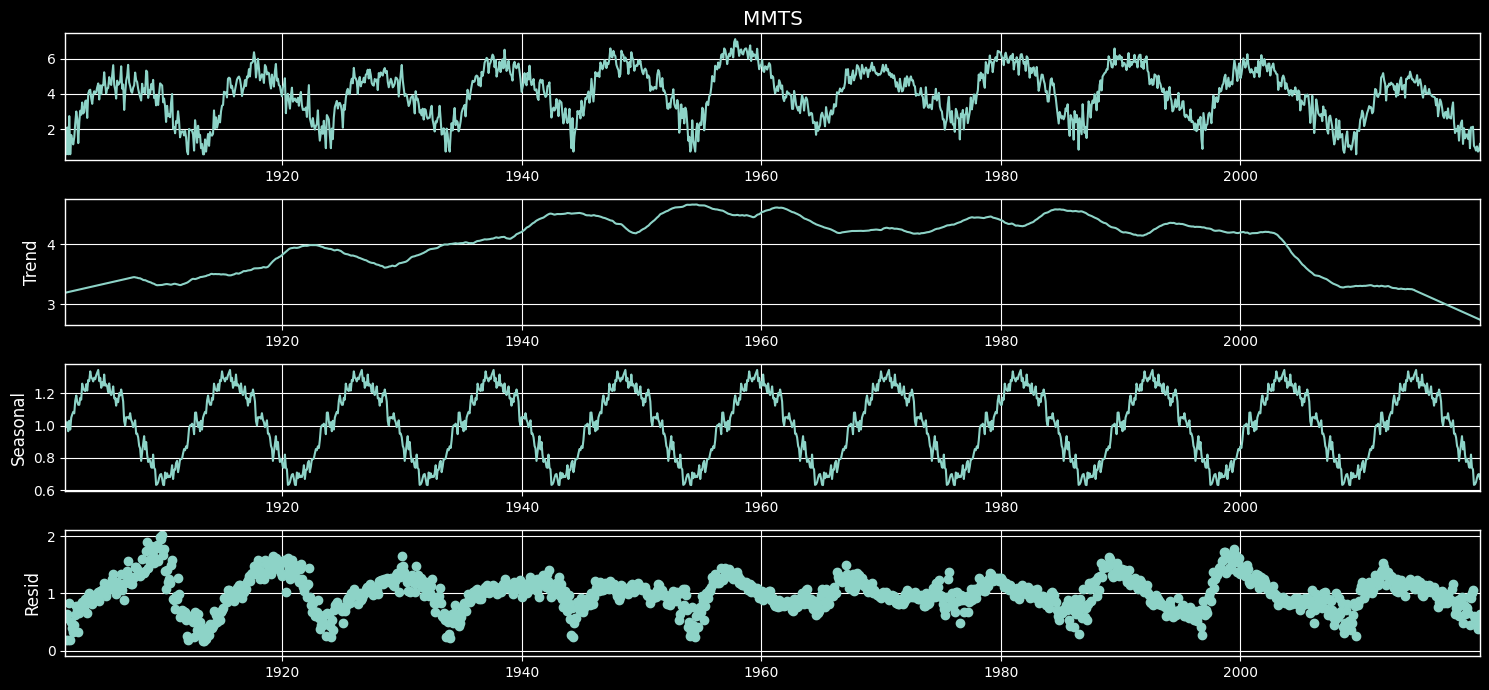

In [1630]:
adecomp_obj = seasonal_decompose(sundata_transformed.MMTS,
                                 model='multiplicative',
                                 period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

# Gauging its Statistics

- Stationarity Test
- Looking in the ACF and PACF
- Distribution Test

## Stationarity Tests

In [357]:
adf_test(sundata.MMTS)

0
Test Statistic              -1.048121e+01
p-value                      1.212359e-18
#Lags Used                   2.800000e+01
Number of Observations Used  3.223000e+03
Critical Value (1%)         -3.432381e+00
Critical Value (5%)         -2.862437e+00
Critical Value (10%)        -2.567248e+00

In [358]:
adf_test(sundata_transformed.MMTS)

0
Test Statistic              -9.926484e+00
p-value                      2.897836e-17
#Lags Used                   2.600000e+01
Number of Observations Used  3.225000e+03
Critical Value (1%)         -3.432379e+00
Critical Value (5%)         -2.862437e+00
Critical Value (10%)        -2.567247e+00

In [359]:
kpss_test(sundata.MMTS)

0
Test Statistic          0.112224
p-value                 0.100000
Lags Used              36.000000
Critical Value (10%)    0.347000
Critical Value (5%)     0.463000
Critical Value (2.5%)   0.574000
Critical Value (1%)     0.739000

In [360]:
kpss_test(sundata_transformed.MMTS)

0
Test Statistic          0.101916
p-value                 0.100000
Lags Used              36.000000
Critical Value (10%)    0.347000
Critical Value (5%)     0.463000
Critical Value (2.5%)   0.574000
Critical Value (1%)     0.739000

Through the results it seems to be stationary

**A time series with cyclic behavior (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time.**

## ACF & PACF

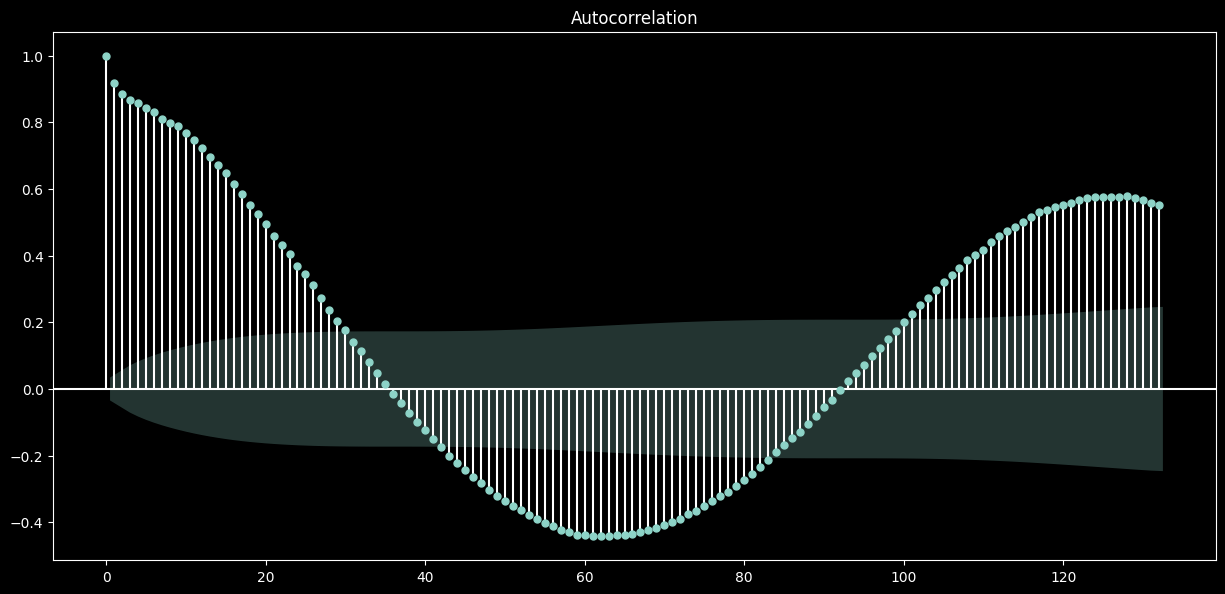

In [361]:
_=plot_acf(sundata.MMTS, lags=128)
_=plot_pacf(sundata.MMTS, lags=128)

In [ ]:
_=plot_acf(sundata_transformed.MMTS.diff().dropna(), lags=128)
_=plot_pacf(sundata_transformed.MMTS.diff().dropna(), lags=128)

In [ ]:
_=plot_acf(sundata_transformed.MMTS, lags=128)
_=plot_pacf(sundata_transformed.MMTS, lags=128)

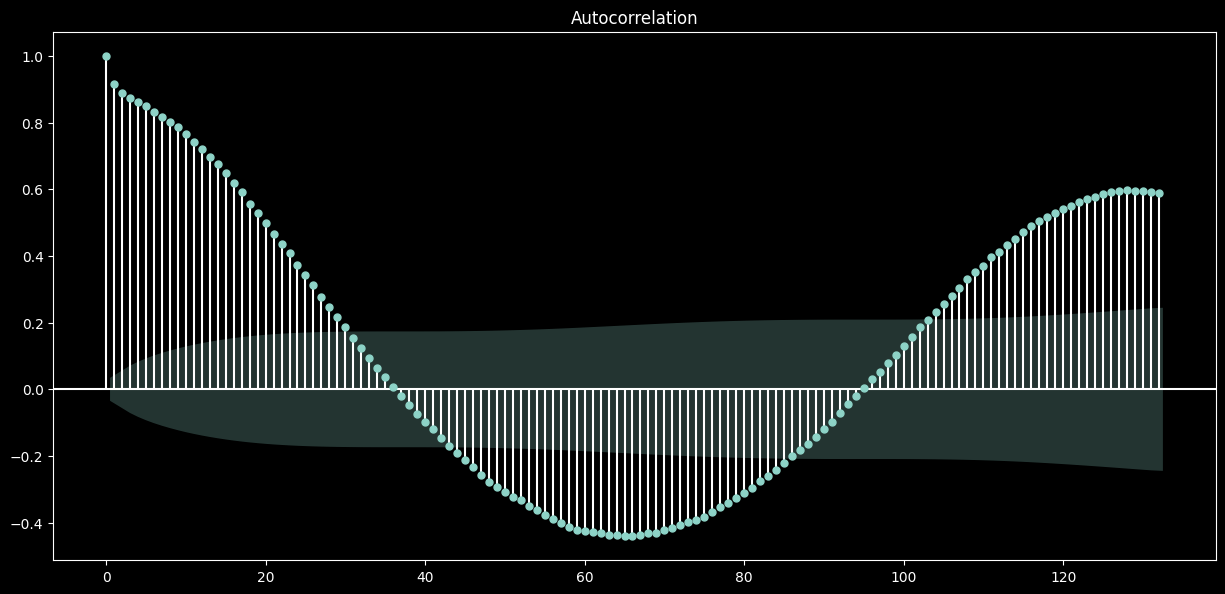

In [363]:
_=plot_acf(sundata_transformed.MMTS.diff().dropna(), lags=128)
_=plot_pacf(sundata_transformed.MMTS.diff().dropna(), lags=128)

# Preparing Modelling Function

As discussed in the previos notebook, the best methodology to predict a time series is via the `Rolling-Origin` forecast, 

i.e ***Utilise the fact that time series data generation is a `frequency` based process and we will get the data accordingly, so it will be best to use that data to make the forecasts***

In [19]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arma_mle import Arma

In [20]:
# AN EXPLANATORY TEMPLATE
def modelling_framework(data, model, model_params, 
                 target_col, feature_cols,
                 test_start, cv_window, ahead_offest,
                 metric='MAPE', ahead_offest_freq='days'):
    
    # Initialisations
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    model = copy.deepcopy(model)
    
    modelling_data = data.copy()
    modelling_data.sort_index(inplace=True)
    
    training_data = data[data.index<test_start].copy()
    testing_data = data[data.index>=test_start].copy()

    train_start = training_data.index[0]
    
    test_start = pd.to_datetime(test_start)
    test_end = modelling_data.index[-1]
    
    # Picking the Metrics
    if metric == 'MAPE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    elif metric == 'MSE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    
    
    # Cross Validation Loop
    for cv_date in training_data.index[-cv_window:]:
        train_end = cv_date-ahead_offest
        
        # Filter the data
        _train_data = training_data.truncate(before=train_start, after=train_end)
        _cv_data = training_data.loc[cv_date].to_frame().T
        
        if feature_cols:
            # Multivariate
            pass
        else:
            # Univariate
            if 'statsmodels' in str(model):
                # Update Model Params Based on library
                model_params['endog'] = _train_data[target_col]
                modeldef = model(**model_params)
                
                fitted_model = modeldef.fit()
                _forecast = fitted_model.predict(start=cv_date, end=cv_date).values[0]
                _actual = _cv_data[target_col].values[0]

        # Update Metric Sheets
        cvDF.loc[cv_date, 'Actual'] = _actual
        cvDF.loc[cv_date, 'Forecast'] = _forecast
        cvDF.loc[cv_date,  metric] = metric_func(_actual, _forecast)
    
    
    # Testing - Using the last fitted_model
    if 'statsmodels' in str(model):
        testDF['Actual'] = testing_data[target_col]
        testDF['Forecast'] = fitted_model.predict(start=test_start, end=test_end)
        testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    # Prepare Overall Metric
    overallDF = pd.DataFrame([cvDF[metric].mean(), testDF[metric].mean()],
                             columns=['Overall '+metric],
                             index=['CV', 'Test'])
    
    return cvDF, testDF, overallDF, fitted_model


In [21]:
from helperhandler import ro_framework

# AR Model

In [1253]:
cycle_dates

Begin        End  Diff_Months
cycle_no                                   
1        1901-11-30 1913-03-31   135.986365
2        1913-04-30 1923-04-30   119.986037
3        1923-05-31 1933-10-31   125.045689
4        1933-11-30 1944-02-29   122.975831
5        1944-03-31 1954-04-30   120.971683
6        1954-05-31 1964-12-31   127.049837
7        1965-01-31 1976-03-31   133.949362
8        1976-04-30 1986-04-30   119.986037
9        1986-05-31 1996-06-30   121.004538
10       1996-07-31 2008-11-30   148.011253
11       2008-12-31 2019-12-31   131.978069

In [1557]:
# 'lags':[1,2,3,4,5,6,7,12,14,18,132] -> 109 test
mdata = sundata_transformed.copy()
testart = '2008-12-31'
respacket=ro_framework(data = mdata, model = AutoReg, model_params = {'lags':[1,3,5,18,132]},
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 148,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=3),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [1558]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                             
===============================================================================
Dep. Variable:                    MMTS   No. Observations:                 1281
Model:             Restr. AutoReg(132)   Log Likelihood                -730.971
Method:                Conditional MLE   S.D. of innovations              0.457
Date:                 Sat, 05 Dec 2020   AIC                             -1.553
Time:                         00:20:26   BIC                             -1.523
Sample:                     11-30-1912   HQIC                            -1.542
                          - 07-31-2008                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2489      0.048      5.152      0.000       0.154       0.344
MMTS.L1        0.6041      0.025     24.204      0.000       0.555       0.653
MMTS.L3        0.2570      0.027      9.550      0.000       0.204       0.310
MMTS.L5        0.1336      0.027      5.030      0.000       0.082       0.186
MMTS.L18      -0.1009      0.014     -6.994      0.000      -0.129      -0.073
MMTS.L132      0.0471      0.018      2.625      0.009       0.012       0.082
                                     Roots                                     
===============================================================================
                    Real          Imaginary           Modulus         Frequency
-------------------------------------------------------------------------------
AR.1              1.0061           -0.0000j            1.0061           -0.0000
AR.2              1.0028           -0.0463j            1.0039           -0.0073
AR.3              1.0028           +0.0463j            1.0039            0.0073
AR.4              0.9995           -0.0861j            1.0032           -0.0137
AR.5              0.9995           +0.0861j            1.0032            0.0137
AR.6              1.0018           -0.1299j            1.0102           -0.0205
AR.7              1.0018           +0.1299j            1.0102            0.0205
AR.8              0.9998           -0.1791j            1.0157           -0.0282
AR.9              0.9998           +0.1791j            1.0157            0.0282
AR.10             0.9928           -0.2290j            1.0189           -0.0361
AR.11             0.9928           +0.2290j            1.0189            0.0361
AR.12             0.9819           -0.2784j            1.0206           -0.0440
AR.13             0.9819           +0.2784j            1.0206            0.0440
AR.14             0.9675           -0.3267j            1.0212           -0.0518
AR.15             0.9675           +0.3267j            1.0212            0.0518
AR.16             0.9503           -0.3734j            1.0210           -0.0596
AR.17             0.9503           +0.3734j            1.0210            0.0596
AR.18             0.9309           -0.4182j            1.0205           -0.0672
AR.19             0.9309           +0.4182j            1.0205            0.0672
AR.20             0.9102           -0.4615j            1.0205           -0.0747
AR.21             0.9102           +0.4615j            1.0205            0.0747
AR.22             0.8883           -0.5042j            1.0214           -0.0822
AR.23             0.8883           +0.5042j            1.0214            0.0822
AR.24             0.8644           -0.5468j            1.0228           -0.0898
AR.25             0.8644           +0.5468j            1.0228            0.0898
AR.26             0.8378           -0.5887j            1.0239           -0.0975
AR.27             0.8378           +0.5887j            1.0239            0.0975
AR.28             0.8084           -0.629

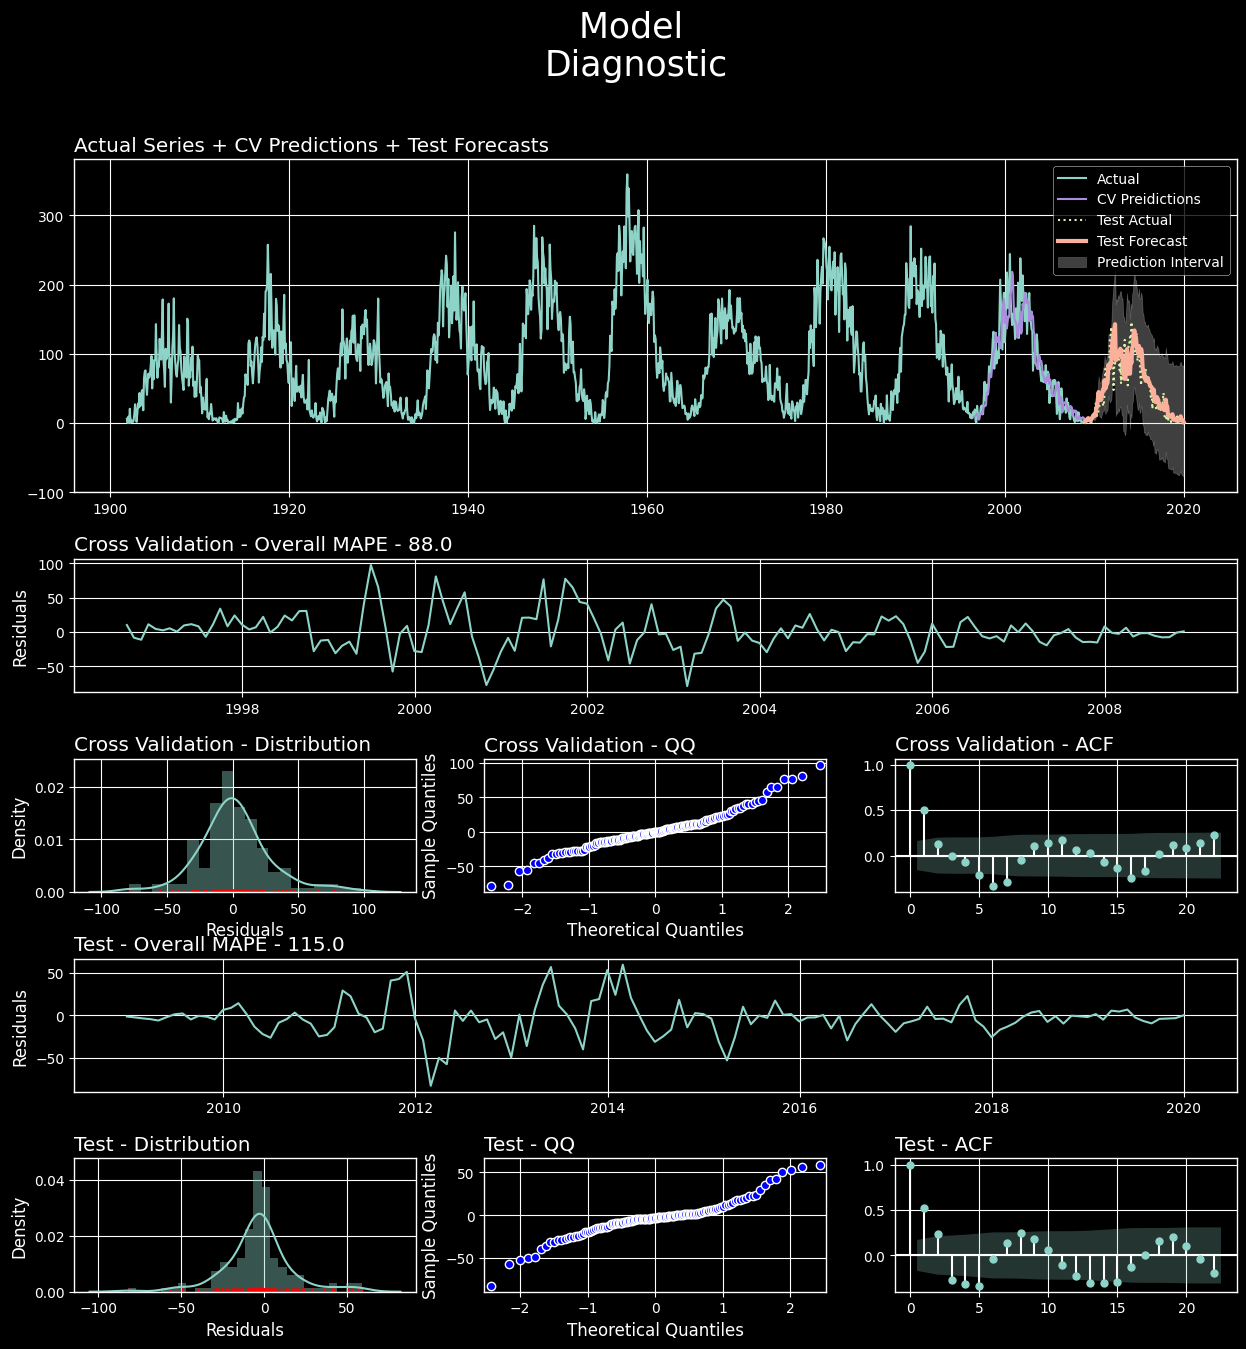

In [1559]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# ARIMA Model

In [1274]:
mdata = sundata_transformed.copy()
testart = '2008-12-31'
respacket=ro_framework(data = mdata, model = ARIMA, model_params = {'order':([1,2], 1, [1,2,3])},
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 148,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=3),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [1275]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                    MMTS   No. Observations:                 1283
Model:             ARIMA([1, 3], 0, 1)   Log Likelihood               -5991.042
Date:                 Fri, 04 Dec 2020   AIC                          11992.083
Time:                         21:47:46   BIC                          12017.868
Sample:                     11-30-1901   HQIC                         12001.764
                          - 09-30-2008                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.1114     21.413      4.255      0.000      49.142     133.081
ar.L1          0.8247      0.034     24.310      0.000       0.758       0.891
ar.L3          0.1440      0.032      4.557      0.000       0.082       0.206
ma.L1         -0.2155      0.044     -4.867      0.000      -0.302      -0.129
sigma2       664.7494     19.525     34.047      0.000     626.482     703.017
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               246.46
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.50
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

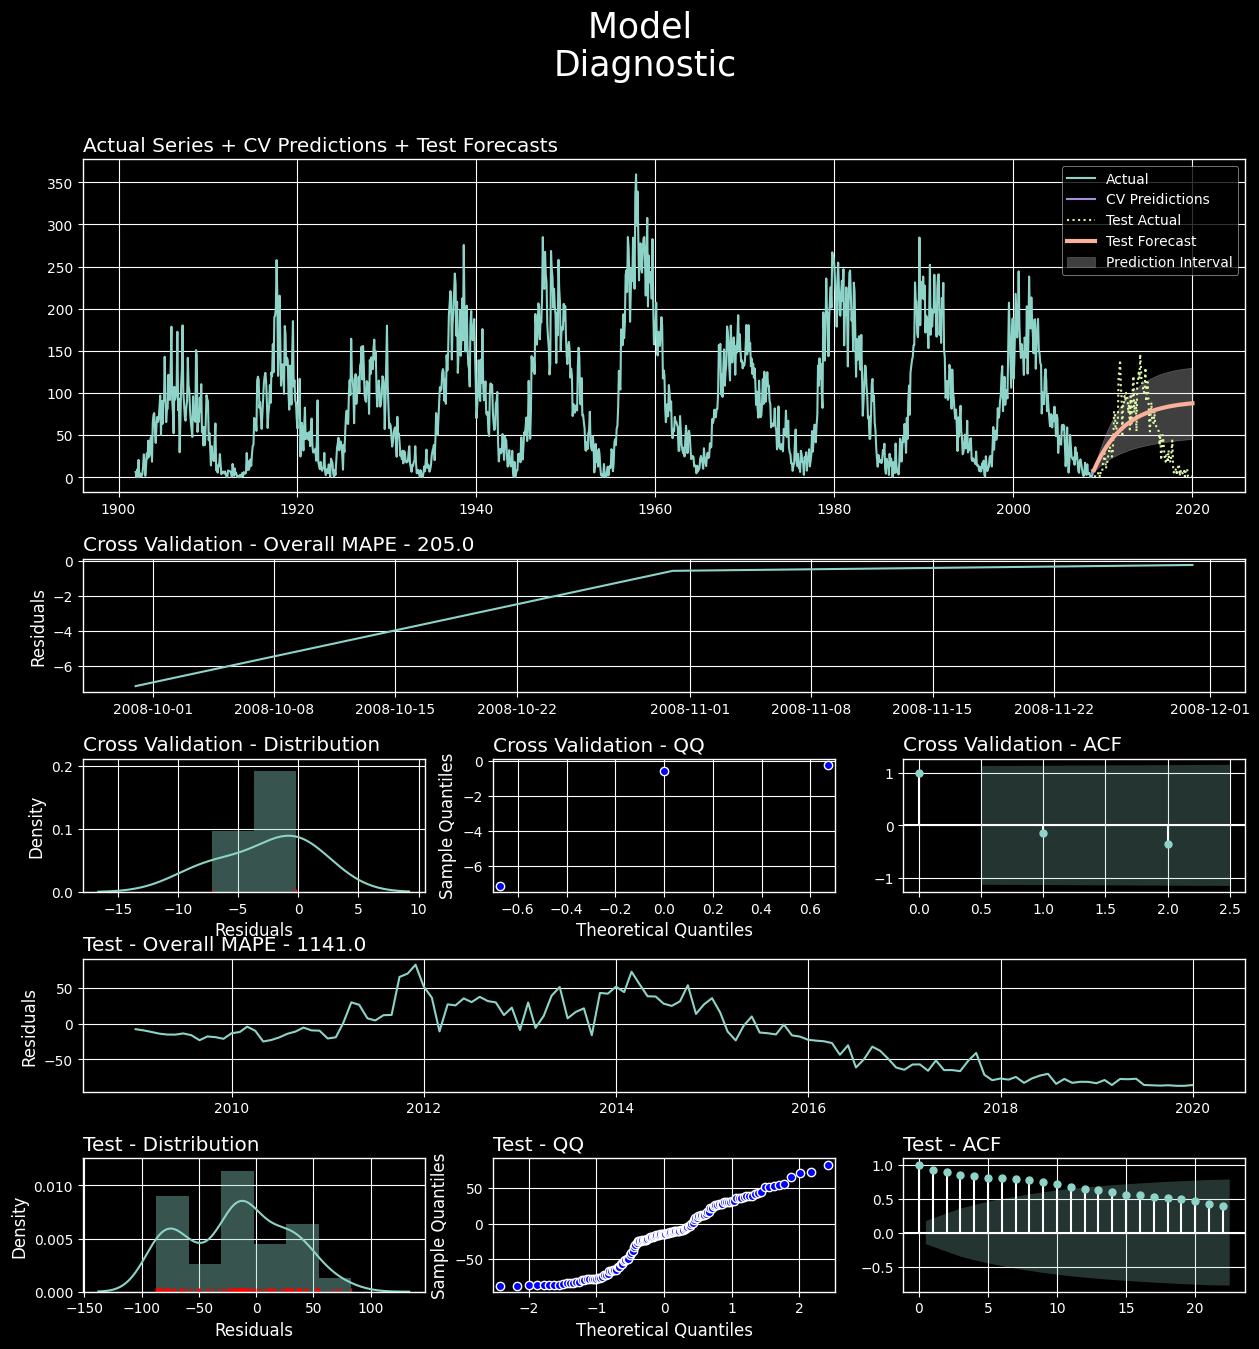

In [1276]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# SARIMA Model

In [1514]:
testart = '2008-12-31'
# order=(3,0,10), seasonal_order=(1,1,0,43)

respacket=ro_framework(data = sundata, model = SARIMAX, model_params = {'order':(3,0,10),
                                                                        'seasonal_order':(1,1,0,43)},
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

KeyboardInterrupt: 

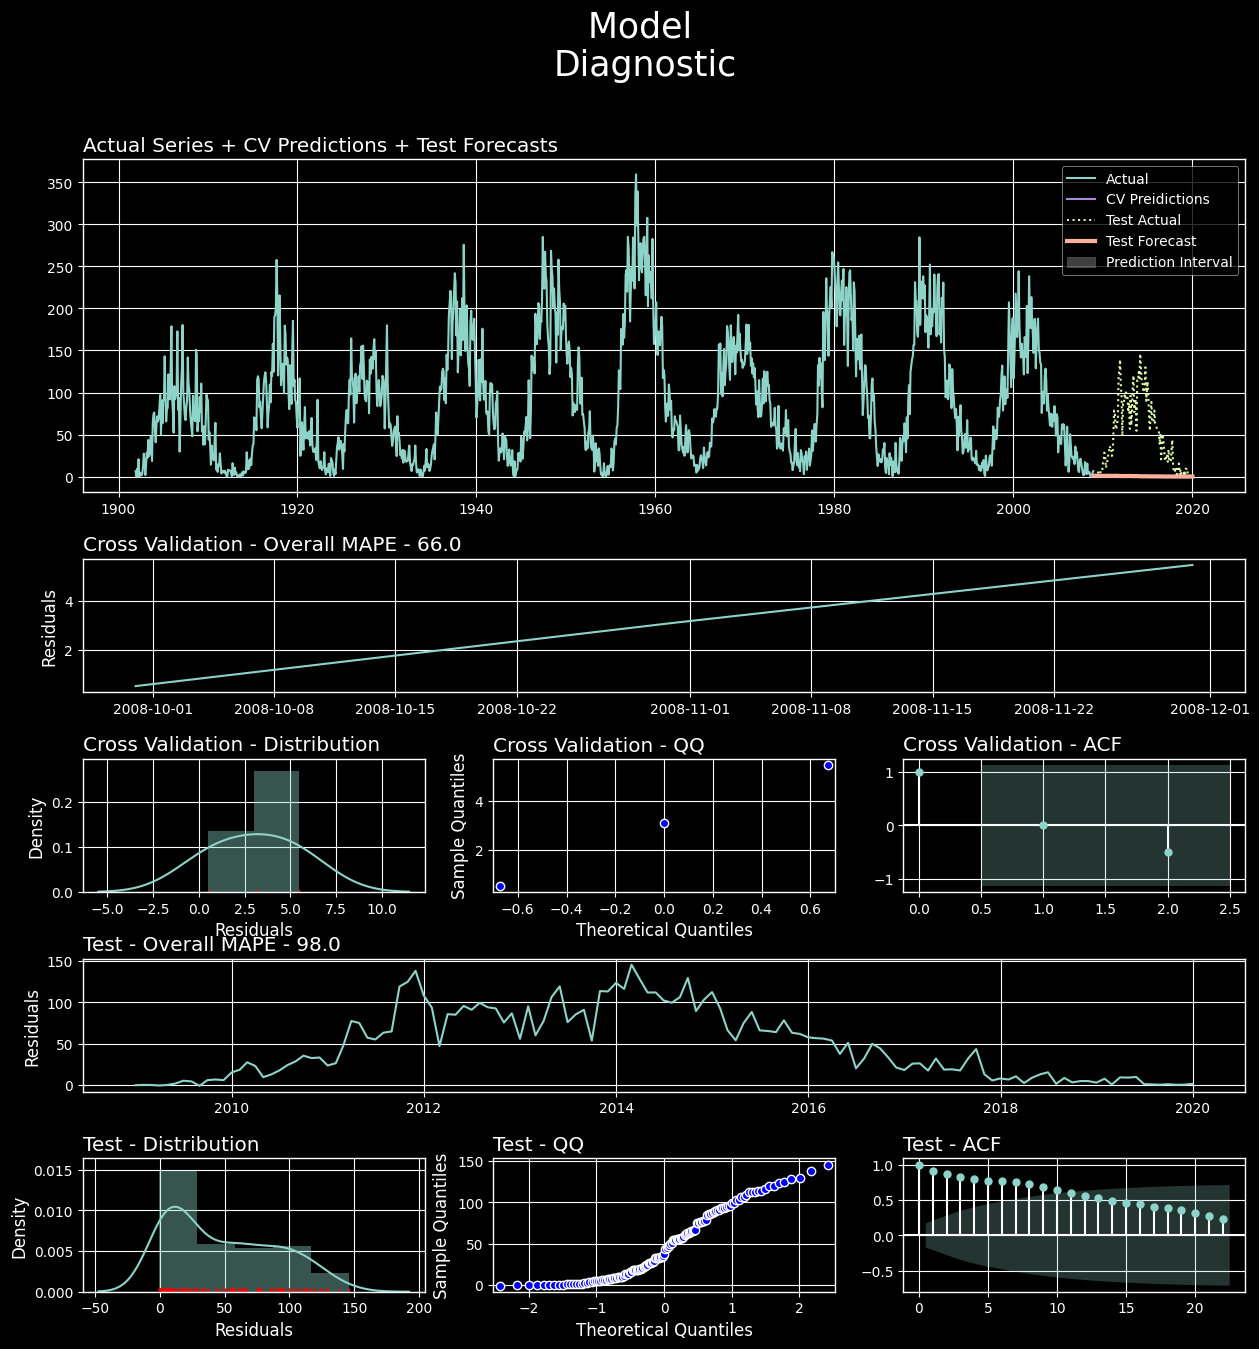

In [1284]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# Prophet Model

Research Paper : [Forecasting at Scale](https://peerj.com/preprints/3190/)

Prophet is a GAM type model, **G**eneralized **A**dditive **M**odel, a model which can be represented as :- 

\begin{equation}
    y_{t} = piecewise\ trend(t) + seasonality(t) + holiday\ effects(t) + i.i.d\ noise(t)
\end{equation}

$piecewise\ trend(t) \Rightarrow$ : Corresponds to L1-Regularized Trend shifts 

$seasonality(t) \Rightarrow$ : Corresponds to Fourier Series

$holiday\ effects(t) \Rightarrow$ : Dummy Variable

$i.i.d\ noise(t) \Rightarrow$ : Classical Time Series Model


[Prophet Model Documentation](https://facebook.github.io/prophet/docs/installation.html#python)

****
<u>Some Parameter Understanding</u> 

`prior_scale` : If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible


## Simple Prophet Model

In [1367]:
class ProphetObjectGenerator:
    def __init__(self):
        self.prophet_model = None
        
    def get_pmodelinstance(self):
        self.prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
        return self.prophet_model
    
    def fit(self):
        pass
        
    def predict(self):
        pass
    
mdata = sundata_transformed.copy()
testart = '2008-12-31'

respacket=ro_framework(data = mdata, model = ProphetObjectGenerator(),
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=12),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

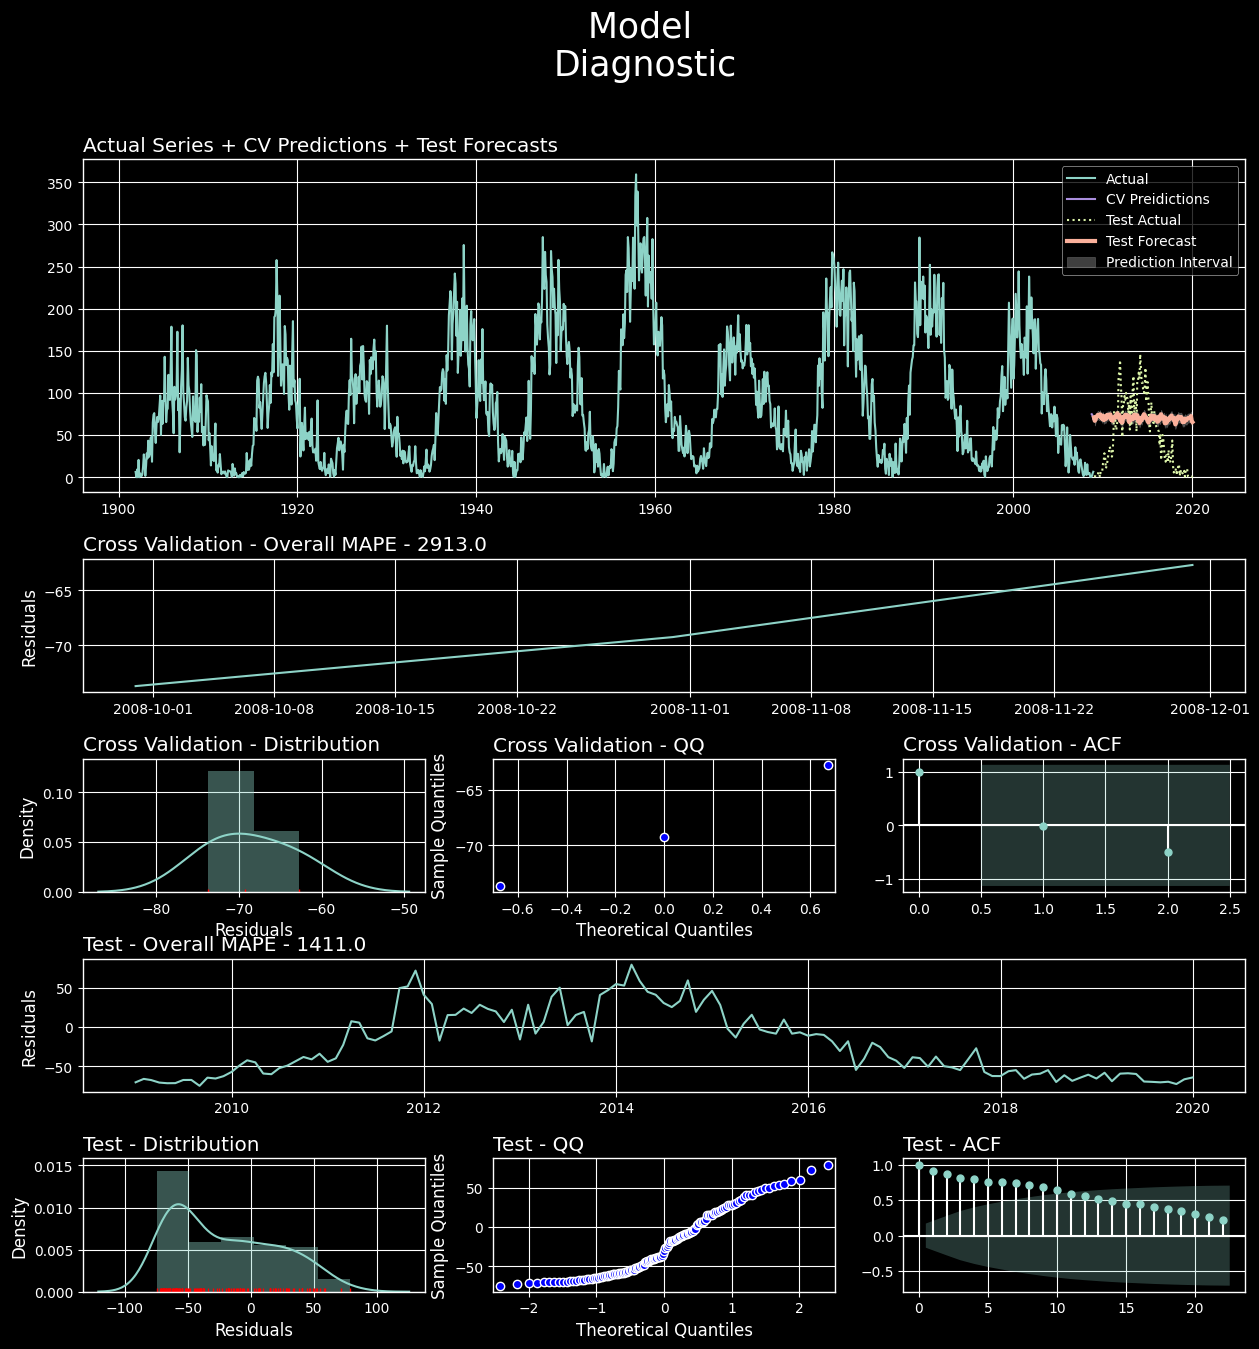

In [1368]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

## Tuned Prophet Model

In [1577]:
class ProphetObjectGenerator:
    def __init__(self):
        self.prophet_model = None
        
    def get_pmodelinstance(self):
        self.prophet_model=Prophet(yearly_seasonality=False,
                                   daily_seasonality=False,
                                   weekly_seasonality=False)

        for eachcycle in [120, 125, 130, 135]:
            self.prophet_model.add_seasonality(name='cycle'+str(eachcycle),
                                               period=eachcycle, mode = 'multiplicative',
                                               fourier_order = int(np.sqrt(eachcycle)),
                                               prior_scale = eachcycle/3)
        return self.prophet_model
        
    def fit(self):
        pass
        
    def predict(self):
        pass
    
mdata = sundata_transformed.copy()
testart = '2008-12-31'

respacket=ro_framework(data = mdata, model = ProphetObjectGenerator(),
#                        back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=12),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

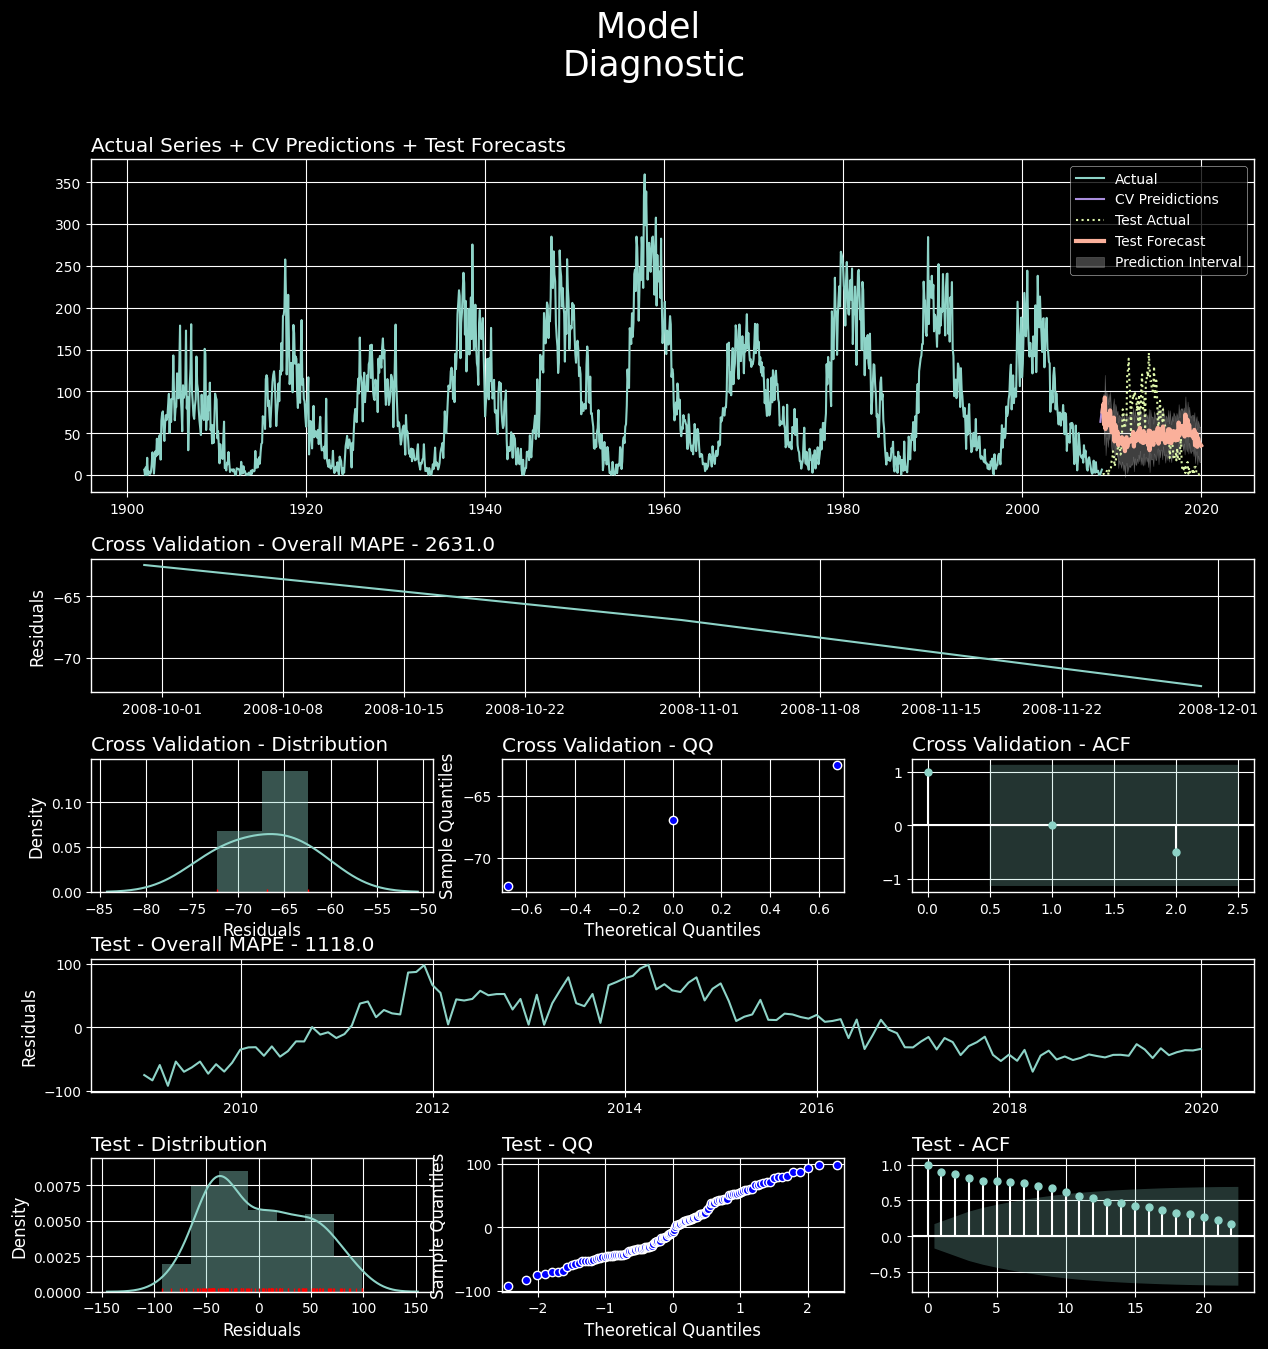

In [1578]:
figProphetTuned=residual_diagnostic(respack=respacket,
                                    training_target=sundata[sundata.index<testart].MMTS)

## Multivariate Prophet Model

In [1599]:
class ProphetObjectGenerator:
    def __init__(self):
        self.prophet_model = None
        
    def get_pmodelinstance(self):
        self.prophet_model=Prophet(yearly_seasonality=False,
                                   daily_seasonality=False,
                                   weekly_seasonality=False)

        for eachcycle in [120, 125, 130, 135]:
            self.prophet_model.add_seasonality(name='cycle'+str(eachcycle),
                                               period=eachcycle, mode = 'multiplicative',
                                               fourier_order = int(np.sqrt(eachcycle)),
                                               prior_scale = eachcycle/3)
        self.prophet_model.add_regressor(name='cycle_month', standardize=True, prior_scale=1000)    
        return self.prophet_model
    
    def fit(self):
        pass

    def predict(self):
        pass

mdata = sundata_transformed.copy()
testart = '2008-12-31'

respacket=ro_framework(data = mdata, model = ProphetObjectGenerator(),
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 2,
                       target_col = 'MMTS',feature_cols=['cycle_month'],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

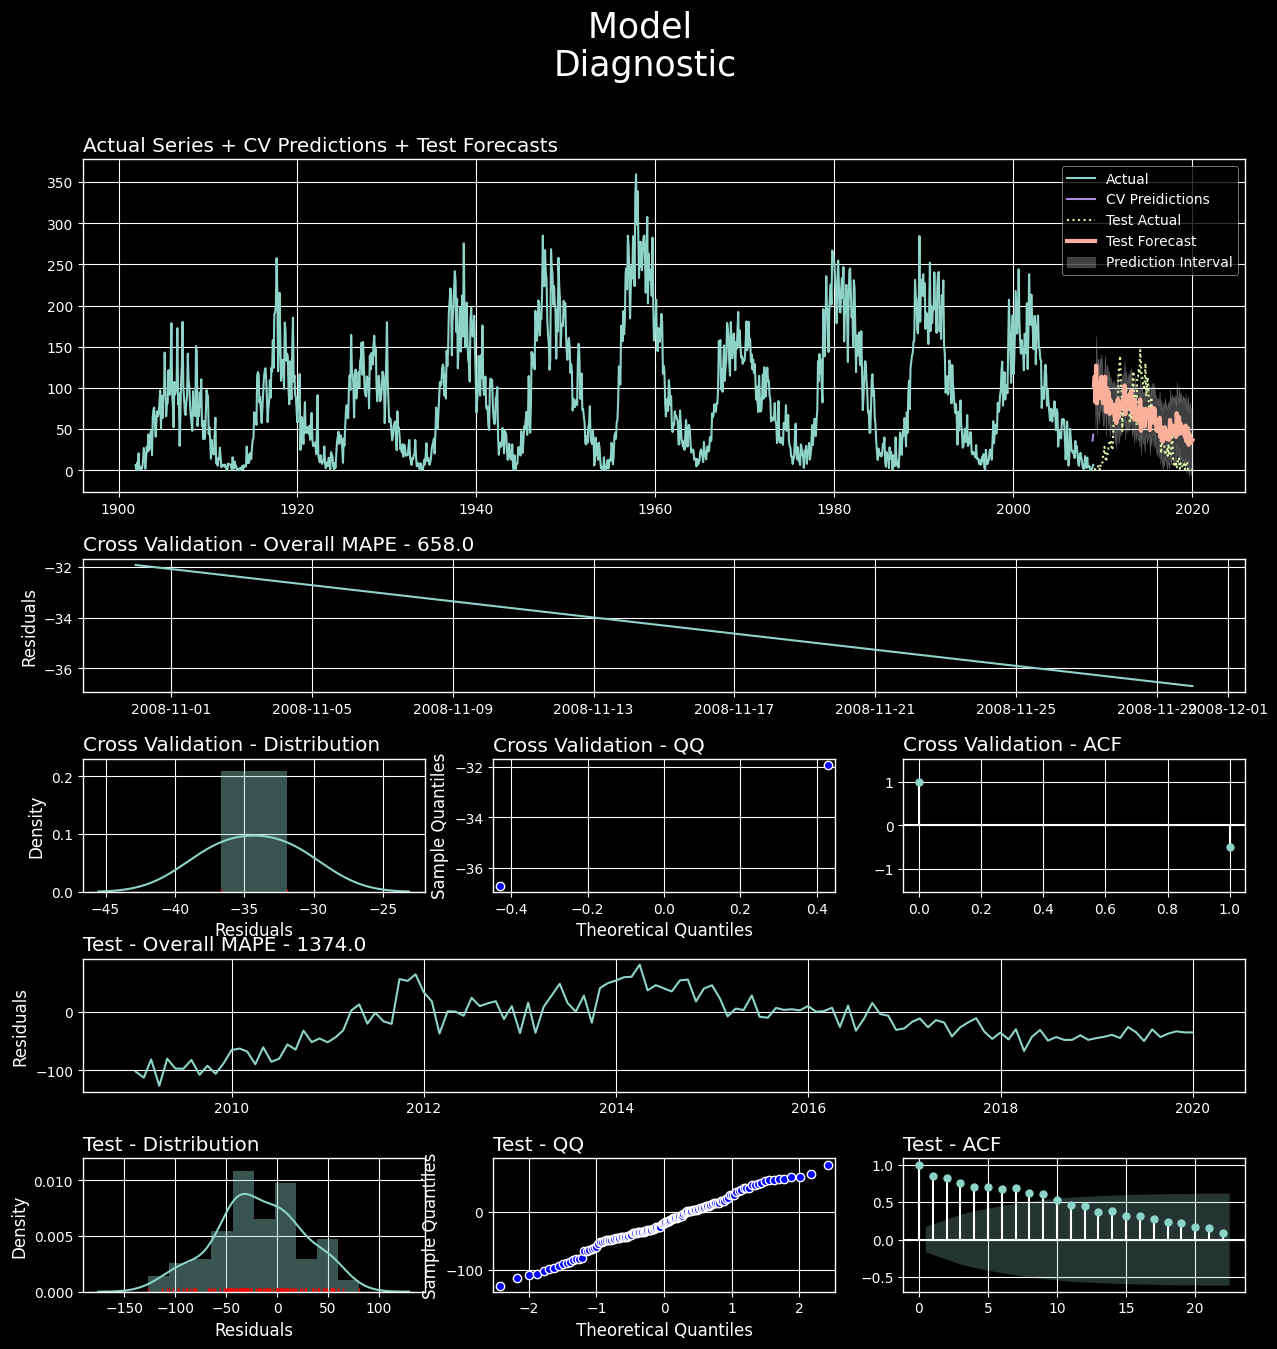

In [1600]:
figProphetTuned=residual_diagnostic(respack=respacket,
                                    training_target=sundata[sundata.index<testart].MMTS)

# Custom Model

Using Fourier Trnasform for the seasonal component

https://ionides.github.io/531w18/midterm_project/project9/531mid.html

https://robjhyndman.com/hyndsight/longseasonality/

https://www.kaggle.com/davidjackson0513/sidc-prophet-sunspots


- First of all, since the series is stretched over 270 years, the rugged behaviour needs to be done away with for the initial analysis, we will smooth the series with the `LOWESS` operation.
- Since the series have `Cyclicity` not `Seasonality`, i.e periodic variations are not of contant interval nature, we will try to fit an `Fourier` series to `mimic` the periodic behaviour.
- Once we have that, we will use that periodic behaviour for our forecast of the Cyclic Pattern
- The remainder will be having some `Time Series` semblance, and to model that we will be using typical `UV` time series model to model that.

For this Time-Series will assume the equation of type :-

\begin{equation}
    CustomModel\Rightarrow Y_{t} = \beta_{0} + \sum_{k=1}^{K}\left [ \alpha_{k}sin\frac{2\pi kt}{m} + \beta_{k}cos\frac{2\pi kt}{m} \right ] + \ TimeSeriesModel(t)
\end{equation}


\begin{equation}
    or
\end{equation}

\begin{equation}
    CustomModel\Rightarrow Y_{t} = \beta_{0} + LowessSmoothedMean(y(t)) + \ TimeSeriesModel(t)
\end{equation}


****

***YOU CAN MIMIC LITERALLY ANYTHING IF YOU KNOW HOW TO USE FOURIER DECOMPOSITION***
<img src='../Materials/fourier_decomp.gif'>


In [ ]:
cycle_dates

## Evaluating which Cycle Smoothing to work with

cycle_month
1      10.490909
2       7.045455
3       8.200000
4       5.627273
5      13.727273
         ...    
145     0.600000
146     0.300000
147     1.200000
148     4.200000
149     6.600000
Name: MMTS, Length: 149, dtype: float64

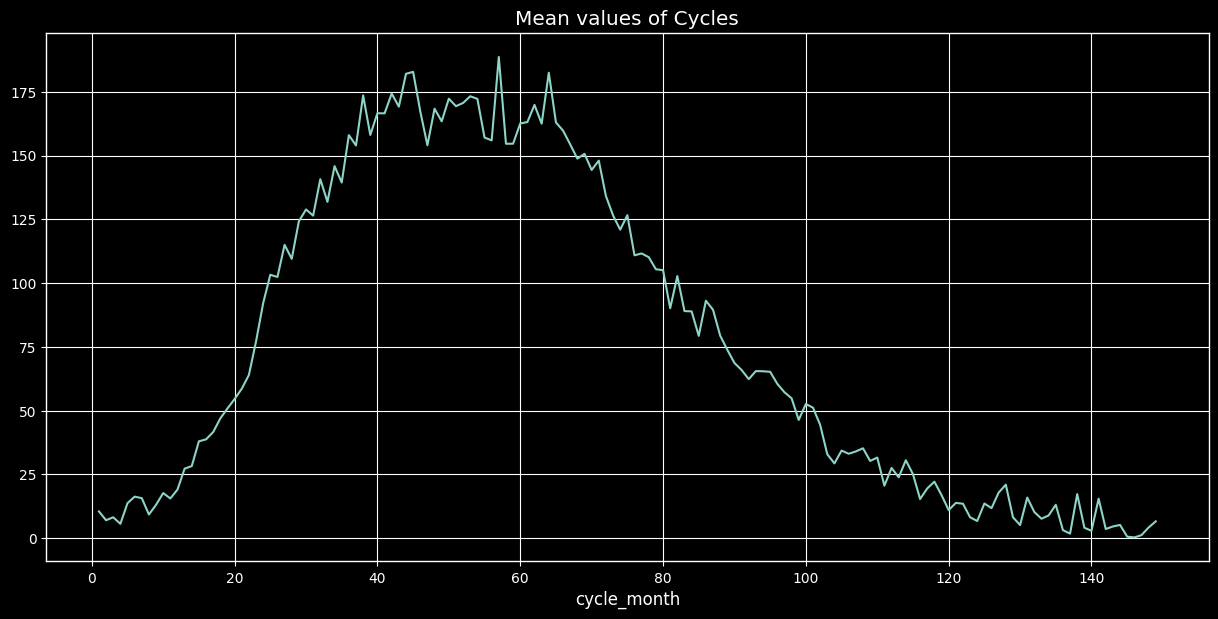

In [1709]:
mean_summed_val = sundata.groupby(['cycle_month']).MMTS.mean()
_=mean_summed_val.plot(title='Mean values of Cycles')
mean_summed_val

### Using LOESS Smoothing

145.0    3.764593
146.0    3.513998
147.0    3.266385
148.0    3.042795
149.0    2.867263
dtype: float64

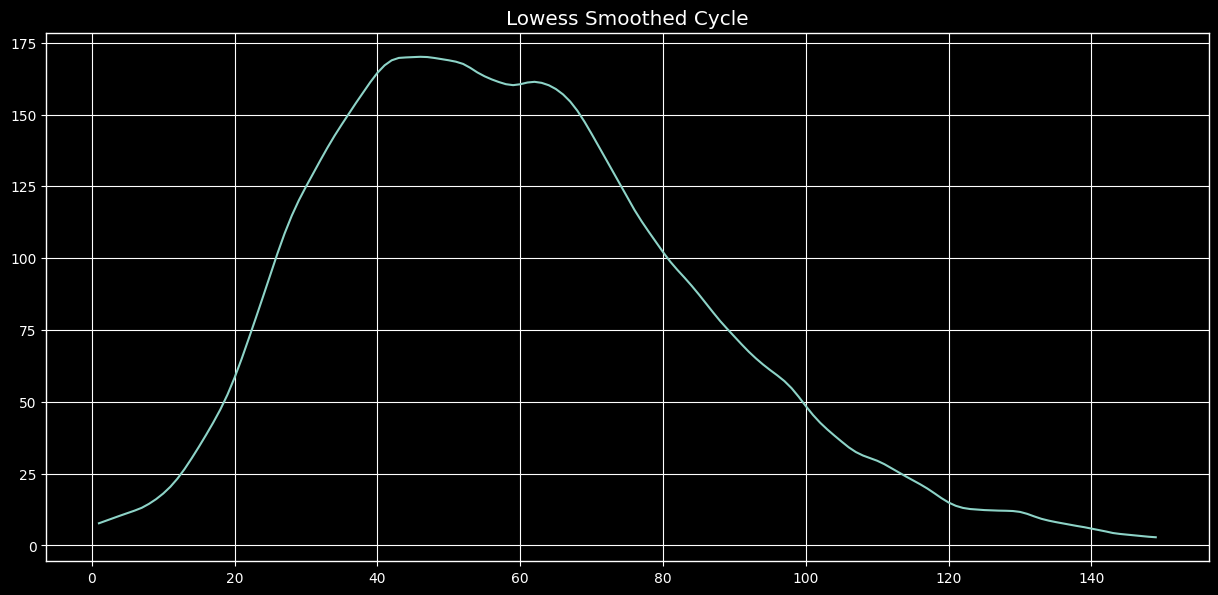

In [1710]:
_endog = mean_summed_val.index
_exog = mean_summed_val.values
lsm = lowess(_exog,_endog, 0.1)
lowes_smoothed = pd.Series(lsm[:,1], lsm[:,0])
_=lowes_smoothed.plot(title='Lowess Smoothed Cycle')
lowes_smoothed.tail()

In [1711]:
sundata['LowessSmoothedCycle'] = sundata.cycle_month.map(lowes_smoothed)

### Using Fourier Smoothing

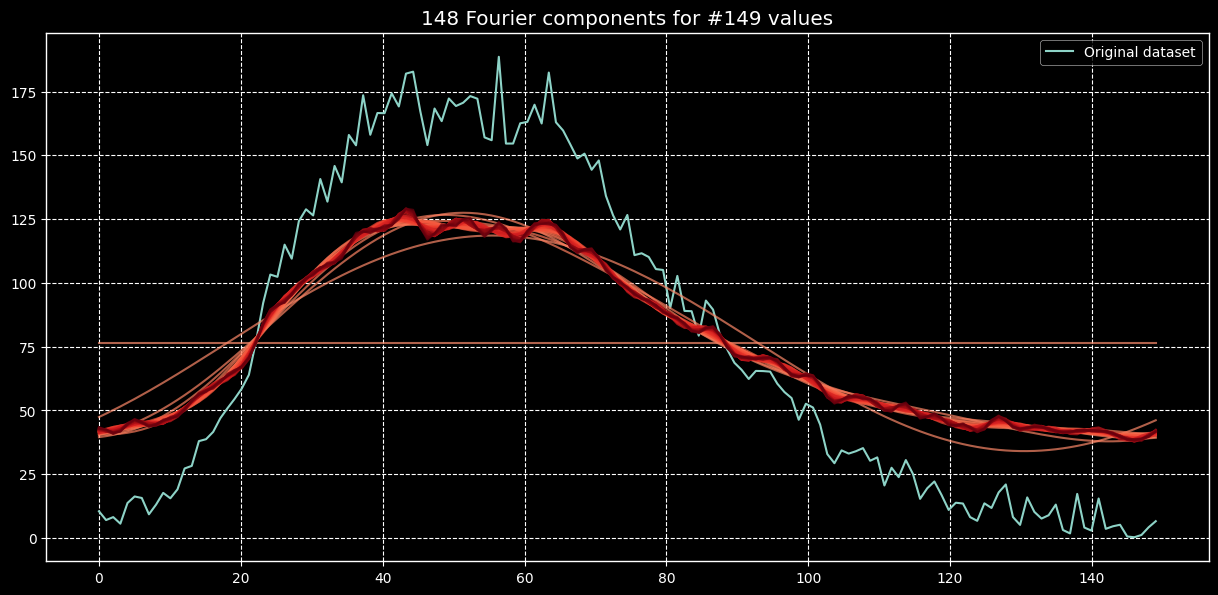

In [1712]:
y = mean_summed_val.values
n = len(y)
x = np.linspace(start=0, stop=n, num=n)

fig, axes  = plt.subplots()

COMPONENTS_BEGIN = 0
COMPONENTS_END = 40
smoothed_df = pd.DataFrame(index=np.arange(n)+1)

colors = np.linspace(start=100, stop=255, num=COMPONENTS_END)
axes.plot(x,y, label="Original dataset")

for i in range(COMPONENTS_BEGIN, COMPONENTS_END):
    Y = np.fft.fft(y)
    np.put(Y, range(i+1, n), 0.0)
    ifft = np.fft.ifft(Y)
    smoothed_df['SmoothedData_'+str(i)] = ifft.real
    axes.plot(x, ifft.real, color=plt.cm.Reds(int(colors[i])), alpha=.70)
sundata['FourierSmoothedCycle'] = sundata.cycle_month.map(smoothed_df.iloc[:,-1])

axes.set_title("{c} Fourier components for #{v} values".format(c=COMPONENTS, v=n))
axes.grid(linestyle='dashed')
_=axes.legend()


### Comparing Two Methods

<AxesSubplot:xlabel='Month'>

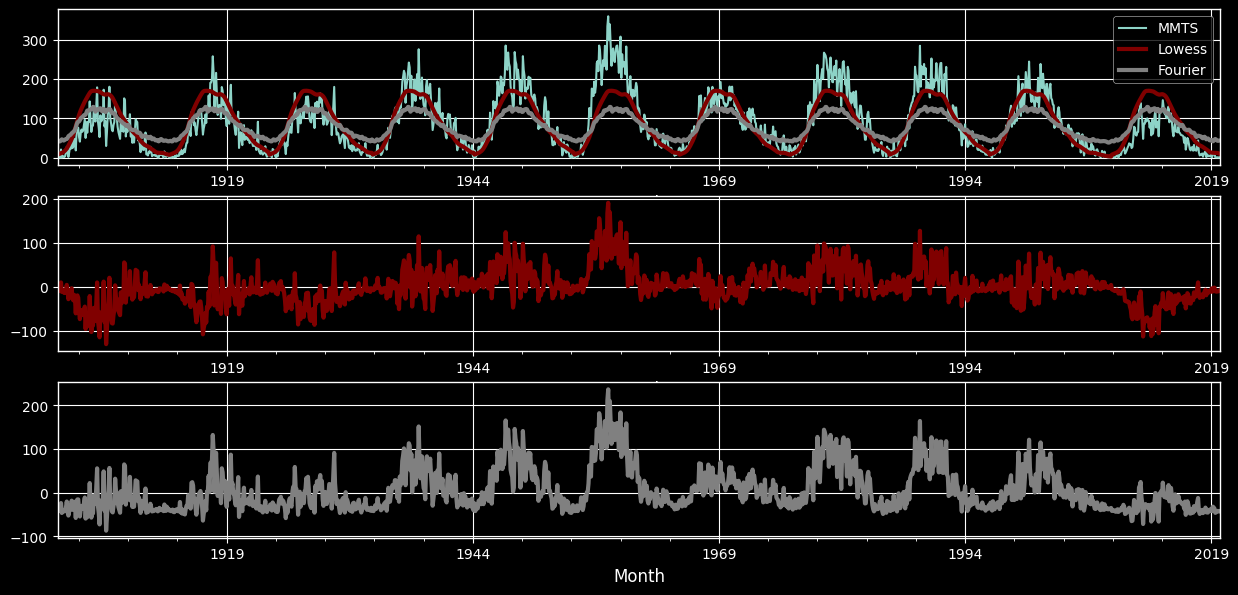

In [1720]:
fig, axes = plt.subplots(3,1)
sundata.MMTS.plot(ax=axes[0])
sundata.LowessSmoothedCycle.plot(linewidth=3, color='maroon', ax=axes[0], label='Lowess')
sundata.FourierSmoothedCycle.plot(linewidth=3, color='gray', ax=axes[0], label='Fourier')
axes[0].legend()

(sundata.MMTS-sundata.LowessSmoothedCycle).plot(linewidth=3, color='maroon', ax=axes[1])
(sundata.MMTS-sundata.FourierSmoothedCycle).plot(linewidth=3, color='gray', ax=axes[2])


## Modelling Residuals

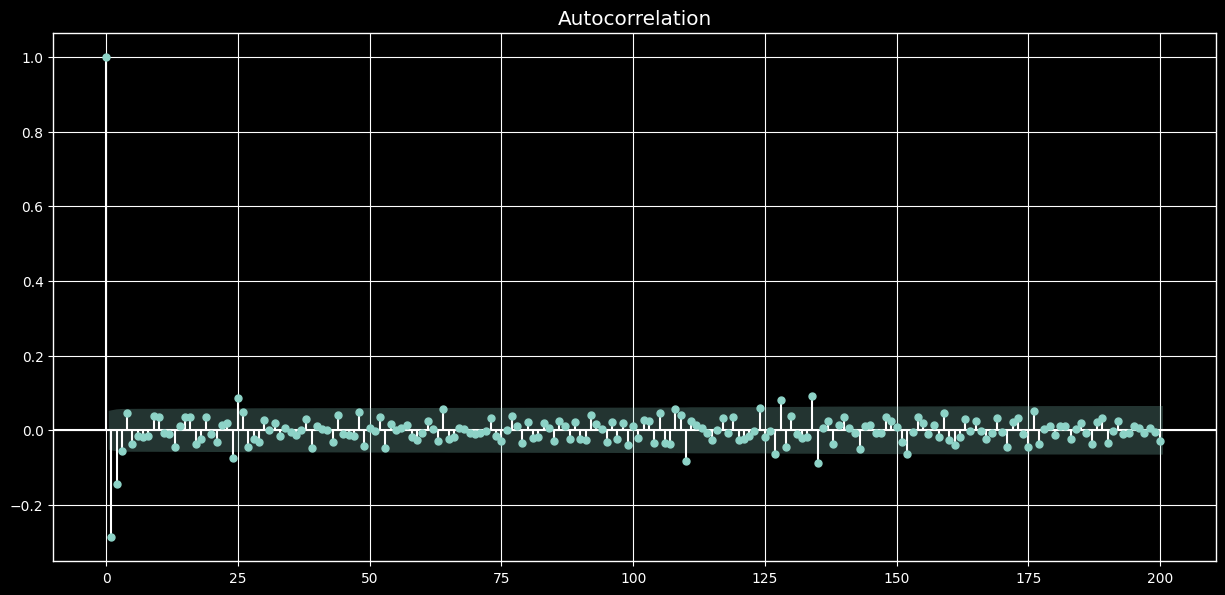

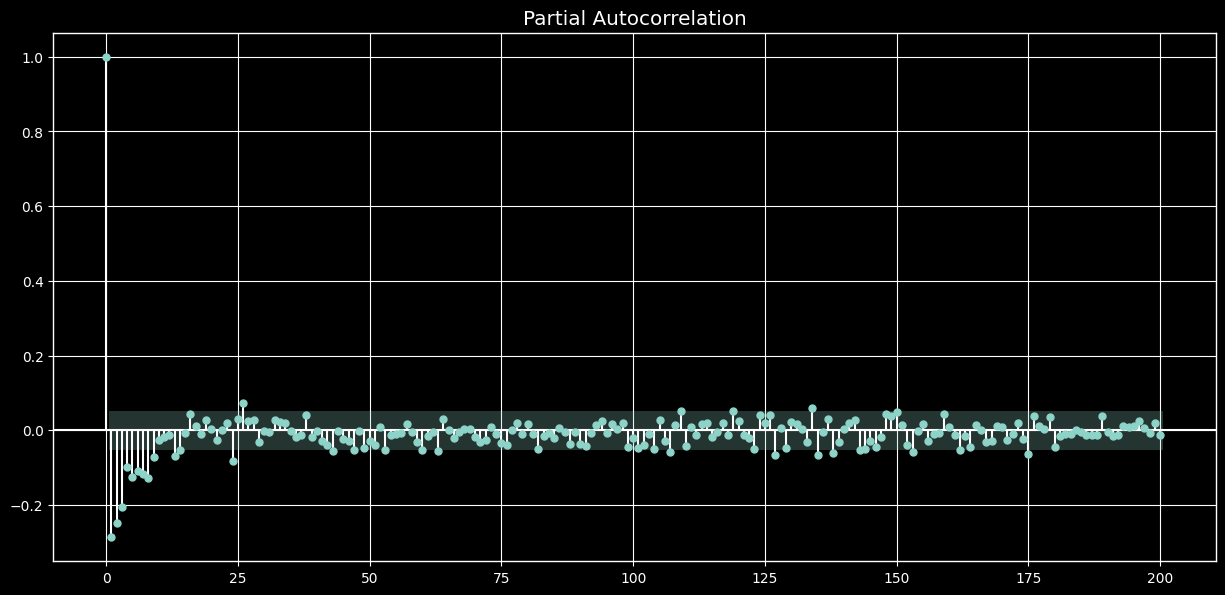

In [1739]:
lowessresid = sundata.MMTS-sundata.LowessSmoothedCycle
lowessresid = lowessresid.diff().dropna()
lowessresid.name = 'CustomModelResidual'
_=plot_acf(lowessresid, lags=200)
_=plot_pacf(lowessresid, lags=200)

In [ ]:
mdata = np.round(lowessresid, 1).copy().to_frame()
testart = '2008-12-31'
respacket=ro_framework(data = mdata, model = ARIMA, model_params = {'order':([1,2,3,4], 1, [1,2,3])},
#                        back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 2,
                       target_col = 'CustomModelResidual', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=3),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
fitted_model.summary()

Month
1901-12-31    -7.11
1902-01-31     8.20
1902-02-28    -9.98
1902-03-31    19.64
1902-04-30   -21.37
              ...  
2019-08-31    -0.31
2019-09-30     0.91
2019-10-31    -0.02
2019-11-30     1.00
2019-12-31     1.93
Freq: M, Name: CustomModelResidual, Length: 1417, dtype: float64

In [1772]:
test_DF.iloc[89,:]

Actual      16.274554
Forecast     0.042265
MAPE        99.740000
Name: 2016-05-31 00:00:00, dtype: float64

In [1761]:
metric_func(-10.467156, -0.029429)

99.72

In [ ]:
_=residual_diagnostic(respack=respacket,
                      training_target=mdata[mdata.index<testart].CustomModelResidual)

In [1730]:
from statsmodels.tsa.arima_model import ARMA

In [1731]:
ARMA()

statsmodels.tsa.arima_model.ARMA

# Introduction to ts-mad

<img src='../Materials/tsmad_logo.png' width='400'>

`ts-mad` stands for - Time Series-Mini Analysis Dashboard,

It is primarily for creating and embedding a mini-dashboard, especially catering to the time-series data analysis

NOTE : This project is still in its beta-phase, were there to be any issues, kindly raise them on - [Github Issues](https://github.com/ag-ds-bubble/ts-mad/issues)

In [ ]:
import tsmad as tmd
tboard = tmd.TsmadBoard(tsdata=sundata[-500:].copy(),
                       data_desc=dataobj.long_description, 
                       target_columns=['MMTS'], dt_freq='M',
                       freq_conv_agg = 'mean', force_interactive=True)

In [ ]:
tboard.get_board()

# Random Testing Space

In [ ]:
# from helperhandler import dataHolder
# dataHolder.load_data()
# dataobj = dataHolder.bucket['sunspots']
# sundata = dataobj.data.copy()

In [ ]:
# %load_ext autoreload
# %autoreload 2
# import tsmad as tmd
# from tsmad import TSMAD_CONFIGS

In [ ]:
# tboard = tmd.TsmadBoard(tsdata=sundata[-500:].copy(),
#                        data_desc=dataobj.long_description, 
#                        target_columns=['MMTS'], dt_freq='M',
#                        freq_conv_agg = 'mean')
# TSMAD_CONFIGS['plotting.default_engine'] = 'Interactive'
# tboard.get_board()

1356.3050839158145

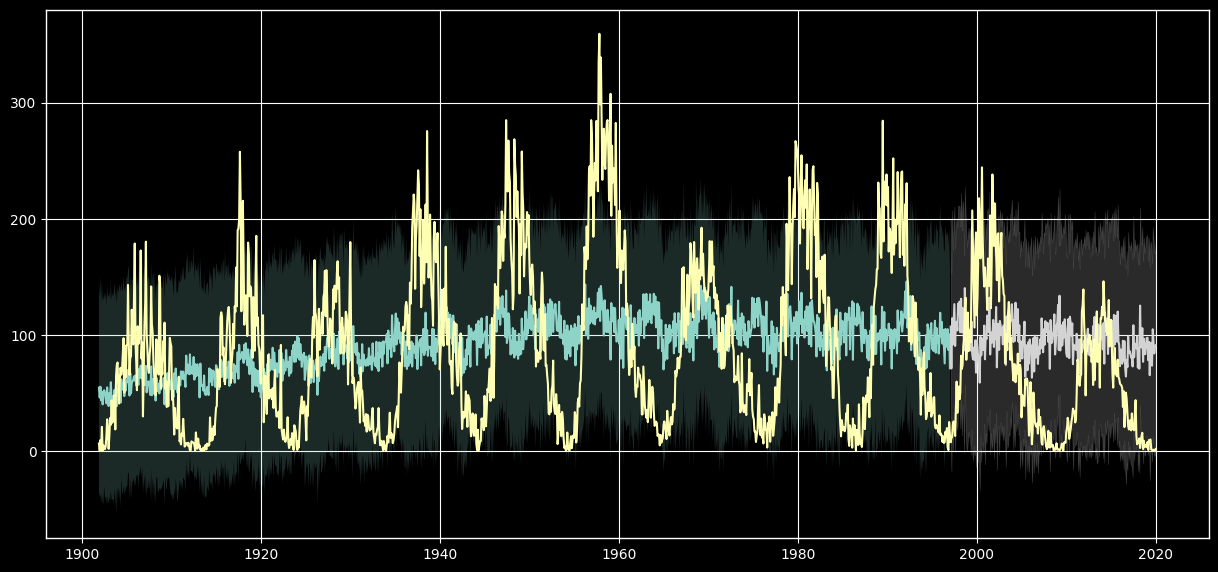

In [1566]:
testart = '1997-01-31'

prophetModel=Prophet(yearly_seasonality=False,
                     daily_seasonality=False,
                     weekly_seasonality=False)

# prophetModel.add_seasonality(name='cycle1', period=128, fourier_order = 64, prior_scale=100)

for eachcycle in [120, 125, 130, 135]:
    prophetModel.add_seasonality(name='cycle'+str(eachcycle),
                                 period=eachcycle, mode = 'multiplicative',
                                 fourier_order = int(np.sqrt(eachcycle)), prior_scale = eachcycle/3)

prophetModel.add_regressor(name='cycle_month', standardize=True, prior_scale=1000)


modellingData=sundata.copy()
modellingData=modellingData.reset_index().rename(columns={'Month':'ds', 'MMTS':'y'})
modellingData['floor'] = 0.0
traindata = modellingData[modellingData.ds<testart].copy()
testdata = modellingData[modellingData.ds>=testart].copy()


prophetModel.fit(traindata)
prophetPredictionsTrain=prophetModel.predict()
prophetPredictionsTrain.set_index('ds', inplace=True)
prophetPredictionsTest=prophetModel.predict(testdata)
prophetPredictionsTest.set_index('ds', inplace=True)


fig,pax=plt.subplots()
pax.fill_between(prophetPredictionsTrain.index,
                 prophetPredictionsTrain.yhat_lower, 
                 prophetPredictionsTrain.yhat_upper, alpha=0.2)
pax.plot(prophetPredictionsTrain.yhat)

pax.fill_between(prophetPredictionsTest.index,
                 prophetPredictionsTest.yhat_lower, 
                 prophetPredictionsTest.yhat_upper, color='lightgray', alpha=0.2)
pax.plot(prophetPredictionsTest.yhat, color='lightgray')

pax.plot(modellingData.set_index('ds').y)

# MAPE
y_actuals = testdata.y.values
y_preds = prophetPredictionsTest.yhat.values
abs((y_actuals-y_preds)/y_actuals).mean()*100

In [1304]:
# from fbprophet.plot import add_changepoints_to_plot

# m=Prophet(growth='flat',yearly_seasonality=False,
#           daily_seasonality=False,
#           weekly_seasonality=False,
# #           changepoint_range=1.0,
# #           changepoint_prior_scale=0.01
#          )
# # m.add_seasonality(name='cycle3', period=108, fourier_order = 50)
# # m.add_seasonality(name='cycle2', period=122, fourier_order = 100)
# # m.add_seasonality(name='cycle1', period=132, fourier_order = 100)
# m.add_seasonality(name='11yr', period=132, fourier_order=80)
# m.add_seasonality(name='cycle4', period=143, fourier_order = 50)
# # m.add_seasonality(name='ar', period=20, fourier_order = 2)

# m.fit(tdata[-1967:-647])
# preddf=m.predict(fdata)

# fig = m.plot(preddf)
# a = add_changepoints_to_plot(fig.gca(), m, preddf)

# temp=preddf.yhat.copy().to_frame()
# temp['ac']=tdata[-647:].reset_index().y
# temp = temp.applymap(lambda x : x**3)
# temp.apply(lambda x : metric_func(x.ac, x.yhat), axis=1).mean()traindata

In [1305]:
# fig = m.plot_components(preddf)


In [1306]:
# # Inspired from : https://dsp.stackexchange.com/a/49233/47462

# smoothing_data = pd.DataFrame()
# smoothing_data['y'] = sundata_transformed.MMTS.values

# y = sundata_transformed.MMTS.values
# n = len(y)
# x = np.linspace(start=0, stop=n-1, num=n)

# fig, axes  = plt.subplots(3,1, figsize=(25,35))

# COMPONENTS = [10, 50, int(n/2)]

# for idx, c in enumerate(COMPONENTS):
#     colors = np.linspace(start=100, stop=255, num=c)
#     axes[idx].plot(x,y, label="Original dataset")

#     for i in range(c):
#         Y = np.fft.fft(y)
#         np.put(Y, range(i+1, n), 0.0)
#         ifft = np.fft.ifft(Y)
#         axes[idx].plot(x, ifft.real, color=plt.cm.Reds(int(colors[i])), alpha=.70)
#         smoothing_data['SmoothedData'] = ifft.real

#     axes[idx].set_title("First {c} fourier components".format(c=c))
#     axes[idx].grid(linestyle='dashed')
#     axes[idx].legend()



In [1430]:
# test_DF['t']=((test_DF.Forecast-test_DF.Actual)/test_DF.Actual)*100
# test_DF.mean()